## Imports

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

import random
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

from models import *
from utils import *
from train import *
from bvc import *
from gen_data import *

sns.set_theme(style='white', font_scale=1.25)

seed = 1234
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
v_idx = 164

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Feedforward BNN

In [1]:
X_train, Y_train = load_data('./data/', 'feedforward_train.pkl')
X_test, Y_test = load_data('./data/', 'feedforward_test.pkl')
X_valid, Y_valid = load_data('./data/', 'feedforward_valid.pkl')

batch_size = 200   # number of data points in each mini-batch
n_train = 10000    # number of data used, from 1 to len(X_train)
n_epochs = 50      # number of training epochs

train_dataset = BNN_Dataset(X_train[:n_train], Y_train[:n_train])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = BNN_Dataset(X_test, Y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = BNN_Dataset(X_valid, Y_valid)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

NameError: name 'load_data' is not defined

#### 1. Parameter grid search: number of layers vs number of hidden units

Repeat 50 times to obtain the main final evaluation loss for each parameter set.

In [ ]:
hidden_dims=[2, 4, 8, 16, 32, 64, 128, 256]
n_layerss=[1, 2, 3, 4, 5, 6, 7, 8]

avg_final_eval_loss = repeated_param_grid_search(
    hidden_dims, n_layerss, n_repeats=30,
    **{'_type':'FF', 'train_loader':train_dataloader, 'valid_loader':valid_dataloader, 'test_loader':test_dataloader, 'n_epochs':n_epochs})

Best hidden unit: 256, best layers: 4


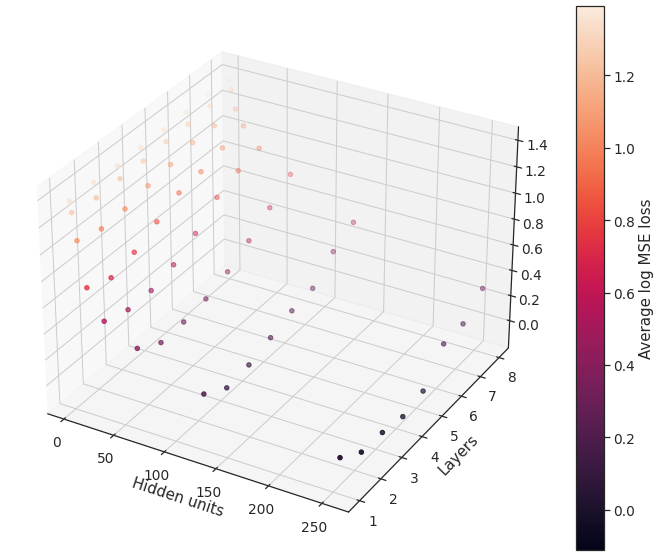

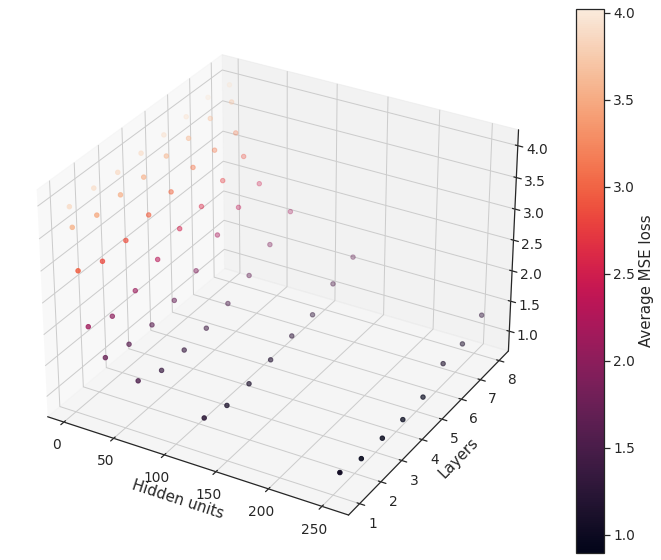

In [5]:
hidden_dims=[2, 4, 8, 16, 32, 64, 128, 256]
n_layerss=[1, 2, 3, 4, 5, 6, 7, 8]
avg_final_eval_loss = torch.load('./temp/param_search_feedforward.pt')
r, c = find_argmin_in_matrix(avg_final_eval_loss)
print(f'Best hidden unit: {hidden_dims[r]}, best layers: {n_layerss[c]}')
plot_3d_scatter(x=hidden_dims, y=n_layerss, z=np.log(avg_final_eval_loss),
               x_label='Hidden units', y_label='Layers', z_label='Average log MSE loss', fname='feedforward_log')
plot_3d_scatter(x=hidden_dims, y=n_layerss, z=avg_final_eval_loss,
               x_label='Hidden units', y_label='Layers', z_label='Average MSE loss', fname='feedforward')
torch.save(avg_final_eval_loss, './temp/param_search_feedforward.pt')

####  2. Learning with best parameter

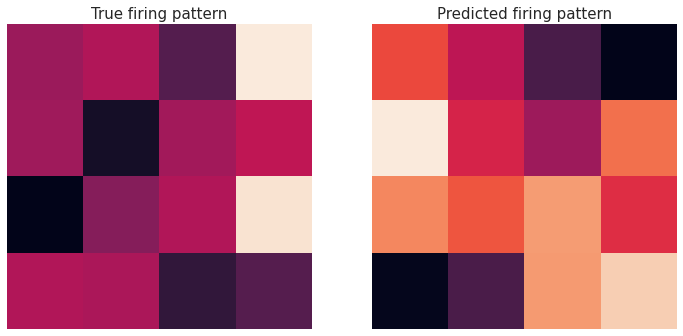

Initial eval loss: 0.7535295367240906
Epoch 1: training loss 0.5326889860630035, eval loss 0.3384387373924255. Time elapsed: 0 h 0 m 0 s.
Epoch 51: training loss 0.06861299112439155, eval loss 0.1179944857954979. Time elapsed: 0 h 0 m 12 s.
Epoch 101: training loss 0.049835912436246875, eval loss 0.12539279460906982. Time elapsed: 0 h 0 m 37 s.
Epoch 151: training loss 0.03134164065122604, eval loss 0.13909417390823364. Time elapsed: 0 h 0 m 49 s.
Epoch 201: training loss 0.036919747218489646, eval loss 0.11001837253570557. Time elapsed: 0 h 1 m 0 s.
Training completed with final epoch loss 1.2314532771706581. Time elapsed: 0 h 1 m 12 s.


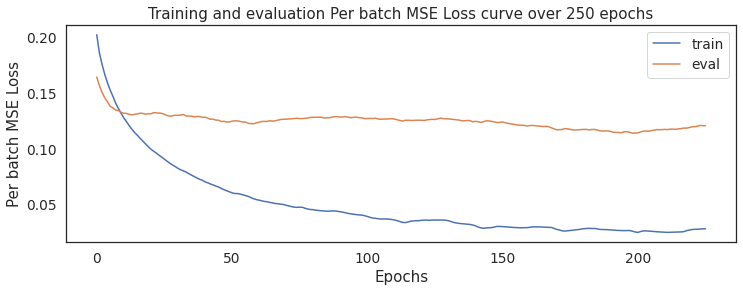

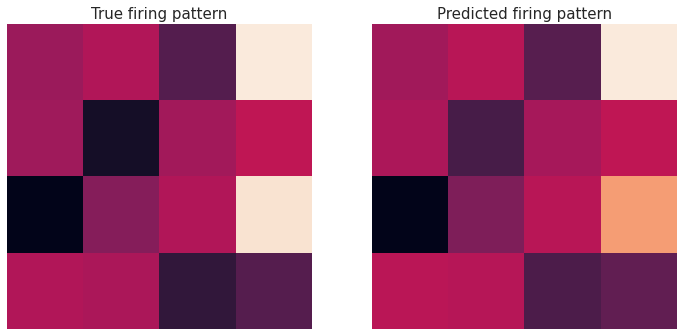

In [10]:
# deep learning model
DNN = FeedForwardDNN(input_dim=16, hidden_dim=256, n_layers=4, output_dim=16).to(device)

# training parameters
optimiser = torch.optim.Adam(DNN.parameters(), lr=1e-3)
criterion = nn.MSELoss()

visualise_prediction(Y_test[v_idx,-1, :], DNN(X_test[v_idx,-1, :]))

train_losses, eval_losses = train(
    model=DNN,
    train_loader=train_dataloader, test_loader=test_dataloader,
    optimiser=optimiser, criterion=criterion, num_epochs=250,
    verbose=True, force_stop=False)

plot_loss_curves(train_losses, eval_losses, loss_func='Per batch MSE Loss', fname='train_curve_ff_mlp')

visualise_prediction(Y_test[v_idx,-1, :], DNN(X_test[v_idx,-1, :])) # visualise after training

#### 3. Testing against predicting the mean

In [12]:
with torch.no_grad(): 
    print('DNN prediction MSE error on test set: ', F.mse_loss(DNN(X_test), Y_test))
    print('Predicting mean MSE error on test set', F.mse_loss(torch.mean(Y_test, dim=0).repeat(1000,1,1), Y_test))

DNN prediction MSE error on test set:  tensor(0.1147, device='cuda:0')
Predicting mean MSE error on test set tensor(0.7493, device='cuda:0')


In [3]:
mses_ff = []
n_repeats = 20
for _ in tqdm(range(n_repeats)):
    DNN = FeedForwardDNN(input_dim=16, hidden_dim=256, n_layers=4, output_dim=16).to(device)

    optimiser = torch.optim.Adam(DNN.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    _, _ = train(
        model=DNN,
        train_loader=train_dataloader, test_loader=test_dataloader,
        optimiser=optimiser, criterion=criterion, num_epochs=250,
        verbose=False, force_stop=False)
    
    mses_ff.append(F.mse_loss(DNN(X_test), Y_test))
    
print(torch.mean(torch.Tensor(mses_ff)))
print(torch.std(torch.Tensor(mses_ff)))

100%|██████████| 20/20 [19:26<00:00, 58.33s/it]

tensor(0.1099)
tensor(0.0060)


### Residual BNN

In [2]:
X_train, Y_train = load_data('./data/', 'residual_train.pkl')
X_test, Y_test = load_data('./data/', 'residual_test.pkl')
X_valid, Y_valid = load_data('./data/', 'residual_valid.pkl')

batch_size = 200   # number of data points in each mini-batch
n_train = 10000    # number of data used, from 1 to len(X_train)
n_epochs = 50      # number of training epochs

train_dataset = BNN_Dataset(X_train, Y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = BNN_Dataset(X_test, Y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = BNN_Dataset(X_valid, Y_valid)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

#### 1. Parameter grid search: number of layers vs number of hidden units

Repeat 50 times to obtain the main final evaluation loss for each parameter set.

In [15]:
hidden_dims=[2, 4, 8, 16, 32, 64, 128, 256]
n_layerss=[1, 2, 3, 4, 5, 6, 7, 8]

avg_final_eval_loss = repeated_param_grid_search(
    hidden_dims, n_layerss, n_repeats=30, **{'_type':'FF', 'train_loader':train_dataloader, 'valid_loader':valid_dataloader, 'test_loader':test_dataloader, 'n_epochs':n_epochs})
torch.save(avg_final_eval_loss, './temp/skip_param_search.pt')

Training on:  NVIDIA GeForce RTX 3070 Laptop GPU
1th repeat: best hidden unit: 256, best layers: 4, final eval loss: 0.8790516257286072, time elapsed: 0 h 1 m 5 s
2th repeat: best hidden unit: 256, best layers: 3, final eval loss: 0.9283478707075119, time elapsed: 0 h 2 m 20 s
3th repeat: best hidden unit: 256, best layers: 3, final eval loss: 0.8991737216711044, time elapsed: 0 h 3 m 42 s
4th repeat: best hidden unit: 256, best layers: 4, final eval loss: 0.8843117356300354, time elapsed: 0 h 5 m 11 s
5th repeat: best hidden unit: 256, best layers: 2, final eval loss: 0.8974523991346359, time elapsed: 0 h 6 m 39 s
6th repeat: best hidden unit: 256, best layers: 3, final eval loss: 0.8541746437549591, time elapsed: 0 h 8 m 5 s
7th repeat: best hidden unit: 256, best layers: 3, final eval loss: 0.882461741566658, time elapsed: 0 h 9 m 28 s
8th repeat: best hidden unit: 256, best layers: 4, final eval loss: 0.9118118435144424, time elapsed: 0 h 10 m 57 s
9th repeat: best hidden unit: 256

Best hidden unit: 256, best layers: 3


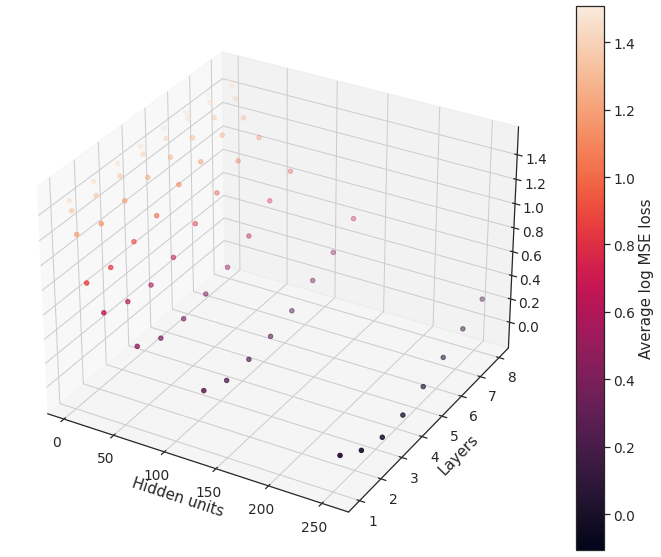

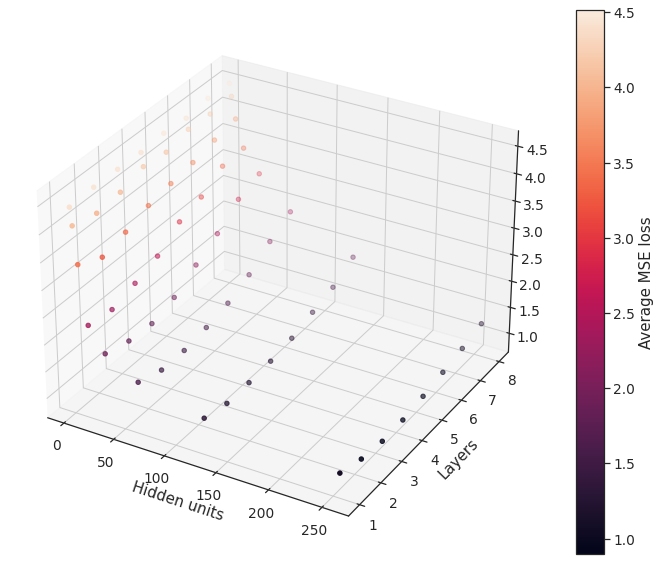

In [11]:
hidden_dims=[2, 4, 8, 16, 32, 64, 128, 256]
n_layerss=[1, 2, 3, 4, 5, 6, 7, 8]
avg_final_eval_loss = torch.load('./temp/skip_param_search.pt')
r, c = find_argmin_in_matrix(avg_final_eval_loss)
print(f'Best hidden unit: {hidden_dims[r]}, best layers: {n_layerss[c]}')
plot_3d_scatter(x=hidden_dims, y=n_layerss, z=np.log(avg_final_eval_loss),
               x_label='Hidden units', y_label='Layers', z_label='Average log MSE loss', fname='skip_log')
plot_3d_scatter(x=hidden_dims, y=n_layerss, z=avg_final_eval_loss,
               x_label='Hidden units', y_label='Layers', z_label='Average MSE loss', fname='skip')


#### 2. Learning with best parameter

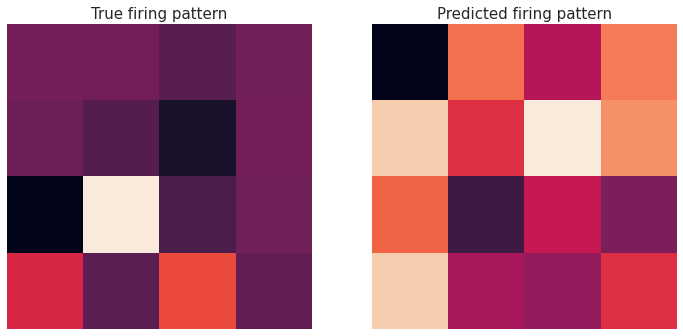

Initial eval loss: 0.8597346663475036
Epoch 1: training loss 0.5450776636600494, eval loss 0.38595343828201295. Time elapsed: 0 h 0 m 0 s.
Epoch 51: training loss 0.07122350029647351, eval loss 0.09659988284111024. Time elapsed: 0 h 0 m 9 s.
Epoch 101: training loss 0.044420418739318845, eval loss 0.09000502675771713. Time elapsed: 0 h 0 m 19 s.
Epoch 151: training loss 0.03547499522566795, eval loss 0.09339165389537811. Time elapsed: 0 h 0 m 42 s.
Epoch 201: training loss 0.03481736771762371, eval loss 0.09049087166786193. Time elapsed: 0 h 0 m 52 s.
Training completed with final epoch loss 1.3668743837624788. Time elapsed: 0 h 1 m 3 s.


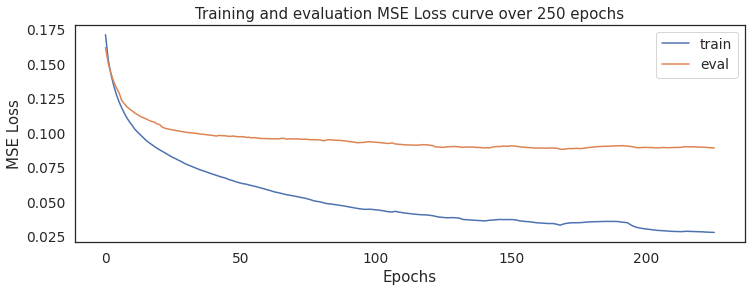

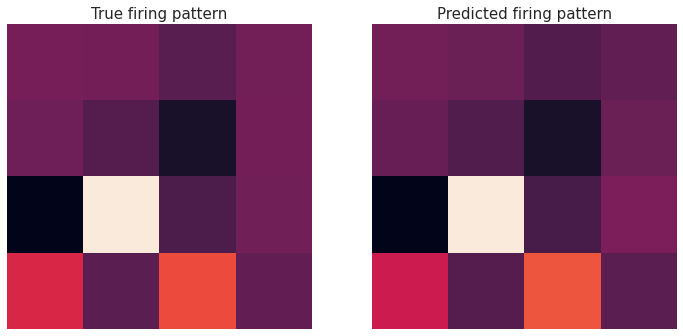

In [14]:
# deep learning model
DNN = FeedForwardDNN(input_dim=16, hidden_dim=256, n_layers=3, output_dim=16).to(device)

# training parameters
optimiser = torch.optim.Adam(DNN.parameters(), lr=1e-3)
criterion = nn.MSELoss()

visualise_prediction(Y_test[v_idx,-1,:], DNN(X_test[v_idx,-1,:]))

train_losses, eval_losses = train(
    model=DNN,
    train_loader=train_dataloader, test_loader=test_dataloader,
    optimiser=optimiser, criterion=criterion, num_epochs=250,
    verbose=True, force_stop=False)

plot_loss_curves(train_losses, eval_losses, loss_func='MSE Loss', fname='train_curve_skip_mlp')

visualise_prediction(Y_test[v_idx,-1,:], DNN(X_test[v_idx,-1,:])) # visualise after training

#### 3. Testing against predicting the mean

In [15]:
with torch.no_grad():
    print('DNN prediction MSE error on test set: ', F.mse_loss(DNN(X_test), Y_test))
    print('Predicting mean MSE error on test set', F.mse_loss(torch.mean(Y_test, dim=0).repeat(1000,1,1), Y_test))

DNN prediction MSE error on test set:  tensor(0.0875, device='cuda:0')
Predicting mean MSE error on test set tensor(0.8530, device='cuda:0')


In [4]:
mses_skip = []
n_repeats = 20
for _ in tqdm(range(n_repeats)):
    DNN = FeedForwardDNN(input_dim=16, hidden_dim=256, n_layers=3, output_dim=16).to(device)

    optimiser = torch.optim.Adam(DNN.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    _, _ = train(
        model=DNN,
        train_loader=train_dataloader, test_loader=test_dataloader,
        optimiser=optimiser, criterion=criterion, num_epochs=250,
        verbose=False, force_stop=False)
    mses_skip.append(F.mse_loss(DNN(X_test), Y_test)) 
print(torch.mean(torch.Tensor(mses_skip)))
print(torch.std(torch.Tensor(mses_skip)))

100%|██████████| 20/20 [17:27<00:00, 52.36s/it]

tensor(0.0881)
tensor(0.0088)


### Recurrent BNN

In [2]:
X_train, Y_train = load_data('./data/', 'recurrent_train.pkl')
X_test, Y_test = load_data('./data/', 'recurrent_test.pkl')
X_valid, Y_valid = load_data('./data/', 'recurrent_valid.pkl')

batch_size = 200   # number of data points in each mini-batch
n_train = 10000    # number of data used, from 1 to len(X_train)
n_epochs = 50      # number of training epochs

train_dataset = BNN_Dataset(X_train, Y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

test_dataset = BNN_Dataset(X_test, Y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

valid_dataset = BNN_Dataset(X_valid, Y_valid)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

#### 1. Using MLP

##### a) Parameter search

In [9]:
hidden_dims=[2, 4, 8, 16, 32, 64, 128, 256]
n_layerss=[1, 2, 3, 4, 5, 6, 7, 8]

avg_final_eval_loss = repeated_param_grid_search(
    hidden_dims, n_layerss, n_repeats=30, **{'_type':'FF', 
                                             'train_loader':train_dataloader, 
                                             'valid_loader':valid_dataloader, 
                                             'test_loader':test_dataloader, 
                                             'n_epochs':n_epochs})

Training on:  NVIDIA GeForce RTX 3070 Laptop GPU
1th repeat: best hidden unit: 256, best layers: 2, final eval loss: 1.5527623891830444, time elapsed: 0 h 1 m 3 s
2th repeat: best hidden unit: 256, best layers: 4, final eval loss: 1.5649966895580292, time elapsed: 0 h 2 m 14 s
3th repeat: best hidden unit: 256, best layers: 3, final eval loss: 1.5370296835899353, time elapsed: 0 h 3 m 37 s
4th repeat: best hidden unit: 256, best layers: 2, final eval loss: 1.5447198748588562, time elapsed: 0 h 4 m 57 s
5th repeat: best hidden unit: 256, best layers: 4, final eval loss: 1.5523774027824402, time elapsed: 0 h 6 m 12 s
6th repeat: best hidden unit: 256, best layers: 2, final eval loss: 1.5437135994434357, time elapsed: 0 h 7 m 33 s
7th repeat: best hidden unit: 256, best layers: 2, final eval loss: 1.543822467327118, time elapsed: 0 h 8 m 54 s
8th repeat: best hidden unit: 256, best layers: 2, final eval loss: 1.540532410144806, time elapsed: 0 h 10 m 14 s
9th repeat: best hidden unit: 256

Best hidden unit: 256, best layers: 2


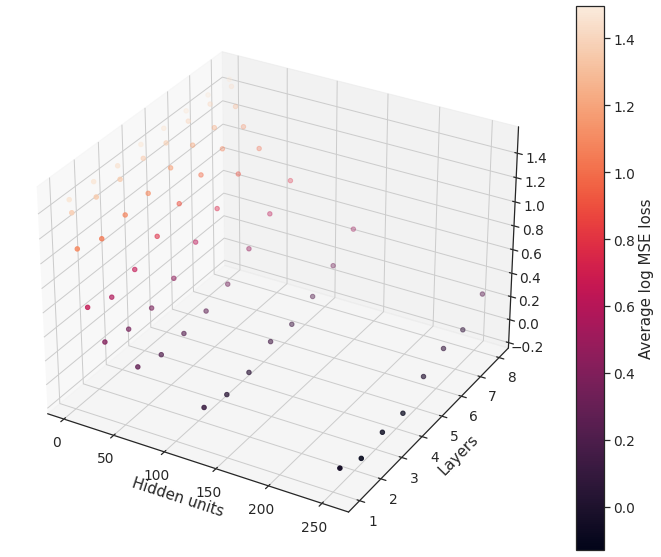

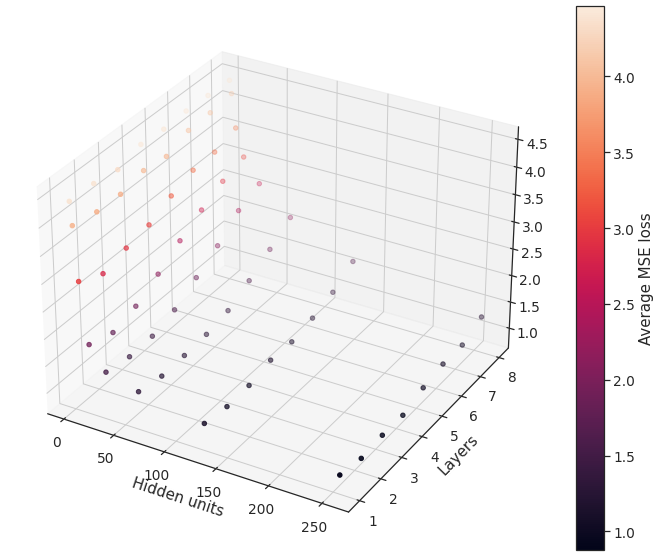

In [12]:
avg_final_eval_loss = torch.load('./temp/recurrent_mlp_param_search_2.pt')
r, c = find_argmin_in_matrix(avg_final_eval_loss)
print(f'Best hidden unit: {hidden_dims[r]}, best layers: {n_layerss[c]}')
plot_3d_scatter(x=hidden_dims, y=n_layerss, z=np.log(avg_final_eval_loss),
               x_label='Hidden units', y_label='Layers', z_label='Average log MSE loss', fname='recurrent_mlp_log')
plot_3d_scatter(x=hidden_dims, y=n_layerss, z=avg_final_eval_loss,
               x_label='Hidden units', y_label='Layers', z_label='Average MSE loss', fname='recurrent_mlp')
# torch.save(avg_final_eval_loss, './temp/recurrent_mlp_param_search_2.pt')

##### b) Learning with best parameter

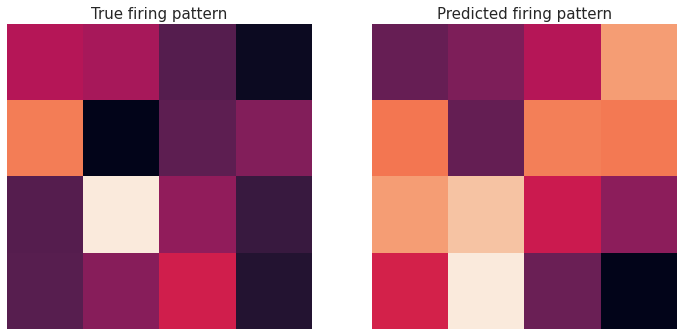

Initial eval loss: 1.0498868703842164
Epoch 1: training loss 0.6074763178825379, eval loss 0.4622791349887848. Time elapsed: 0 h 0 m 0 s.
Epoch 51: training loss 0.2445964977145195, eval loss 0.24783865809440614. Time elapsed: 0 h 0 m 8 s.
Epoch 101: training loss 0.23546747893095016, eval loss 0.2437878131866455. Time elapsed: 0 h 0 m 17 s.
Epoch 151: training loss 0.2304460933804512, eval loss 0.24429772198200225. Time elapsed: 0 h 0 m 26 s.


KeyboardInterrupt: 

In [4]:
# deep learning model
DNN = FeedForwardDNN(input_dim=16, hidden_dim=256, n_layers=2, output_dim=16).to(device)

# training parameters
optimiser = torch.optim.Adam(DNN.parameters(), lr=1e-3)
criterion = nn.MSELoss()

visualise_prediction(Y_test[v_idx,-1,:], DNN(X_test[v_idx,-1,:]))

train_losses, eval_losses = train(
    model=DNN,
    train_loader=train_dataloader, test_loader=test_dataloader,
    optimiser=optimiser, criterion=criterion, num_epochs=250,
    verbose=True, force_stop=False)

plot_loss_curves(train_losses, eval_losses, loss_func='MSE Loss',fname='train_curve_fb_mlp')

visualise_prediction(Y_test[v_idx,-1,:], DNN(X_test[v_idx,-1,:])) # visualise after training

##### c) Testing against predicting the mean

In [18]:
with torch.no_grad():
    print('DNN prediction MSE error on test set: ', F.mse_loss(DNN(X_test), Y_test))
    print('Predicting mean MSE error on test set', F.mse_loss(torch.mean(Y_test, dim=0).repeat(1000,1,1), Y_test))

DNN prediction MSE error on test set:  tensor(0.2441, device='cuda:0')
Predicting mean MSE error on test set tensor(0.9991, device='cuda:0')


In [3]:
mses_rec_mlp = []
n_repeats = 20
for _ in range(n_repeats):
    DNN = FeedForwardDNN(input_dim=16, hidden_dim=256, n_layers=2, output_dim=16).to(device)

    optimiser = torch.optim.Adam(DNN.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    _, _ = train(
        model=DNN,
        train_loader=train_dataloader, test_loader=test_dataloader,
        optimiser=optimiser, criterion=criterion, num_epochs=250,
        verbose=False, force_stop=False)
    mses_rec_mlp.append(F.mse_loss(DNN(X_test), Y_test)) 
print(torch.mean(torch.Tensor(mses_rec_mlp)))
print(torch.std(torch.Tensor(mses_rec_mlp)))

tensor(0.2678)
tensor(0.0063)


#### 2. Using RNN

##### a) Parameter search

In [8]:
hidden_dims=[2, 4, 8, 16, 32, 64, 128, 256]
n_layerss=[1, 2, 3, 4, 5, 6, 7, 8]

avg_final_eval_loss = repeated_param_grid_search(
    hidden_dims, n_layerss, n_repeats=30, **{'_type':'RNN', 
                                             'train_loader':train_dataloader, 
                                             'valid_loader':valid_dataloader, 
                                             'test_loader':test_dataloader, 
                                             'n_epochs':n_epochs})

Training on:  NVIDIA GeForce RTX 3070 Laptop GPU
1th repeat: best hidden unit: 256, best layers: 3, final eval loss: 2.01944100856781, time elapsed: 0 h 1 m 15 s
2th repeat: best hidden unit: 256, best layers: 2, final eval loss: 2.0092600286006927, time elapsed: 0 h 2 m 40 s
3th repeat: best hidden unit: 256, best layers: 7, final eval loss: 1.9811238646507263, time elapsed: 0 h 4 m 0 s
4th repeat: best hidden unit: 256, best layers: 6, final eval loss: 2.0349889993667603, time elapsed: 0 h 5 m 24 s
5th repeat: best hidden unit: 256, best layers: 5, final eval loss: 2.0187368392944336, time elapsed: 0 h 6 m 48 s
6th repeat: best hidden unit: 256, best layers: 6, final eval loss: 1.9989043176174164, time elapsed: 0 h 8 m 10 s
7th repeat: best hidden unit: 256, best layers: 7, final eval loss: 2.0087122321128845, time elapsed: 0 h 9 m 33 s
8th repeat: best hidden unit: 256, best layers: 2, final eval loss: 1.975893497467041, time elapsed: 0 h 10 m 54 s
9th repeat: best hidden unit: 256,

Best hidden unit: 256, best layers: 3


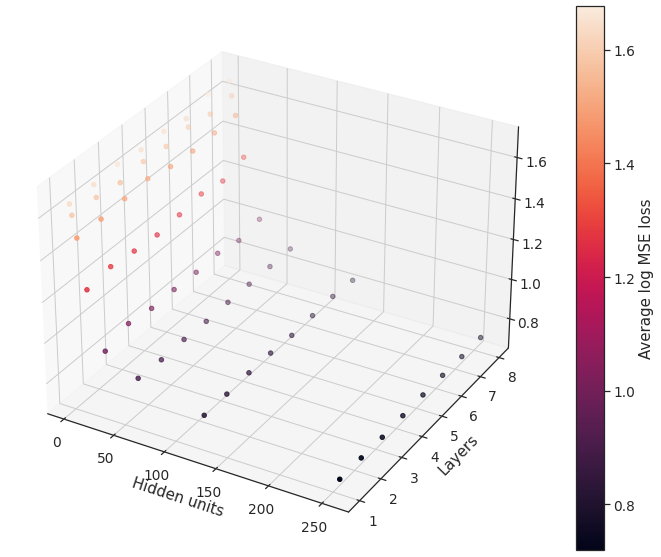

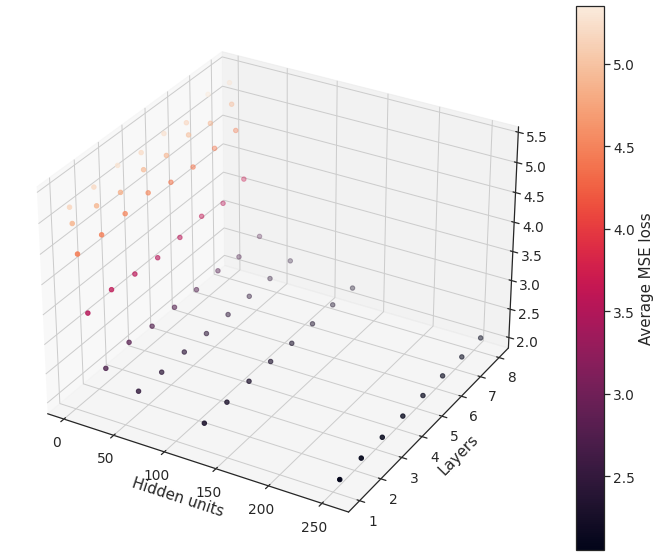

In [15]:
avg_final_eval_loss = torch.load('./temp/recurrent_lstm_param_search_2.pt')
r, c = find_argmin_in_matrix(avg_final_eval_loss)
print(f'Best hidden unit: {hidden_dims[r]}, best layers: {n_layerss[c]}')
plot_3d_scatter(x=hidden_dims, y=n_layerss, z=np.log(avg_final_eval_loss),
               x_label='Hidden units', y_label='Layers', z_label='Average log MSE loss', fname='recurrent_lstm_log')
plot_3d_scatter(x=hidden_dims, y=n_layerss, z=avg_final_eval_loss,
               x_label='Hidden units', y_label='Layers', z_label='Average MSE loss', fname='recurrent_lstm')
# torch.save(avg_final_eval_loss, './temp/recurrent_lstm_param_search_2.pt')

##### b) Learning with best parameter

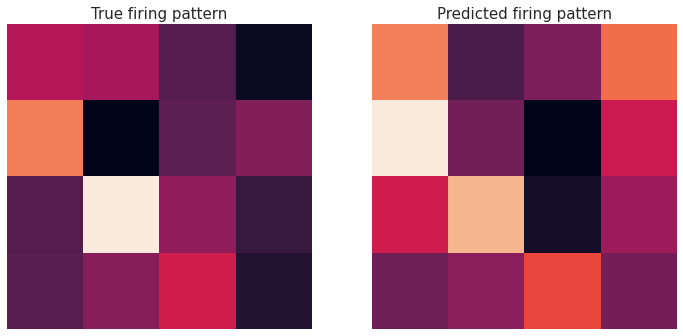

Initial eval loss: 3.87745943069458
Epoch 1: training loss 1.0631785881519318, eval loss 0.6076851725578308. Time elapsed: 0 h 0 m 0 s.
Epoch 51: training loss 0.2836910390853882, eval loss 0.2835961639881134. Time elapsed: 0 h 0 m 11 s.
Epoch 101: training loss 0.2757257628440857, eval loss 0.2758334934711456. Time elapsed: 0 h 0 m 23 s.
Epoch 151: training loss 0.27197328448295593, eval loss 0.272345107793808. Time elapsed: 0 h 0 m 34 s.
Epoch 201: training loss 0.269644957780838, eval loss 0.270080029964447. Time elapsed: 0 h 0 m 46 s.
Epoch 251: training loss 0.2680522567033768, eval loss 0.268839555978775. Time elapsed: 0 h 0 m 58 s.
Epoch 301: training loss 0.26700277864933014, eval loss 0.2678767144680023. Time elapsed: 0 h 1 m 13 s.
Epoch 351: training loss 0.26593241751194, eval loss 0.26684523224830625. Time elapsed: 0 h 1 m 28 s.
Epoch 401: training loss 0.26492963910102846, eval loss 0.2657781481742859. Time elapsed: 0 h 1 m 53 s.
Epoch 451: training loss 0.2641886660456657

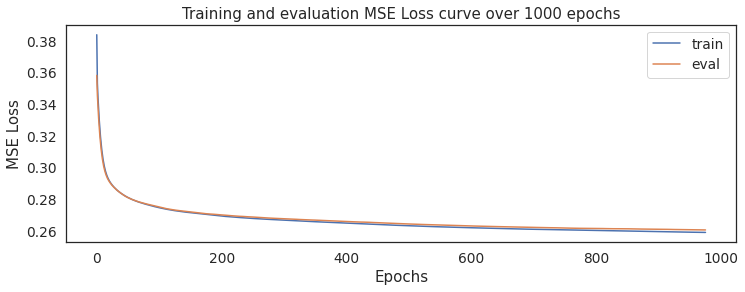

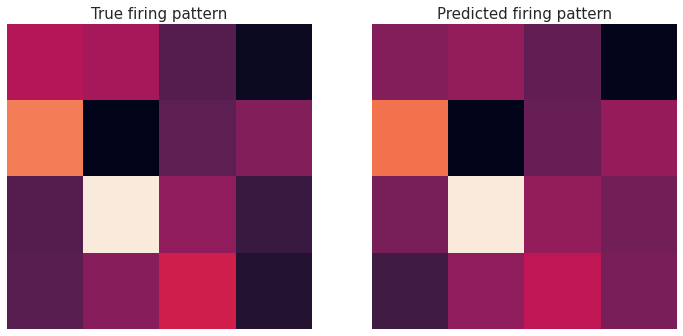

In [5]:
# deep learning model
DNN = RecurrentDNN(input_dim=16, hidden_dim=256, n_linear_layers=3, output_dim=16, n_lstm_layers=1).to(device)

# training parameters
optimiser = torch.optim.Adam(DNN.parameters(), lr=1e-3)
criterion = nn.MSELoss()

_, Y_hats = eval_rnn(DNN, test_dataloader, criterion, save_Y_hat=True)

visualise_prediction(Y_test[v_idx,-1,:], Y_hats[v_idx,-1,:])

train_losses, eval_losses = train_rnn(
    model=DNN,
    train_loader=train_dataloader, test_loader=test_dataloader,
    optimiser=optimiser, criterion=criterion, num_epochs=1000,
    verbose=True, force_stop=False)

plot_loss_curves(train_losses, eval_losses, loss_func='MSE Loss', fname='train_curve_fb_rnn')

_, Y_hats = eval_rnn(DNN, test_dataloader, criterion, save_Y_hat=True)
visualise_prediction(Y_test[v_idx,0-1,:], Y_hats[v_idx,-1,:])

##### c) Testing against predicting the mean

In [6]:
print('DNN prediction MSE error on test set: ', F.mse_loss(Y_hats, Y_test))
print('Predicting mean MSE error on test set', F.mse_loss(torch.mean(Y_test, dim=0).repeat([1000,1,1]), Y_test))

DNN prediction MSE error on test set:  tensor(0.2605, device='cuda:0')
Predicting mean MSE error on test set tensor(0.9991, device='cuda:0')


In [3]:
mses_rec_rnn = []
n_repeats = 20
for _ in tqdm(range(n_repeats)):
    DNN = RecurrentDNN(input_dim=16, hidden_dim=256, n_linear_layers=3, output_dim=16, n_lstm_layers=1).to(device)

    optimiser = torch.optim.Adam(DNN.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    train_losses, eval_losses = train_rnn(
        model=DNN,
        train_loader=train_dataloader, test_loader=test_dataloader,
        optimiser=optimiser, criterion=criterion, num_epochs=1000,
        verbose=False, force_stop=False)

    _, Y_hats = eval_rnn(DNN, test_dataloader, criterion, save_Y_hat=True)
    mses_rec_rnn.append(F.mse_loss(Y_hats, Y_test)) 

print(torch.mean(torch.Tensor(mses_rec_rnn)))
print(torch.std(torch.Tensor(mses_rec_rnn)))

100%|██████████| 20/20 [1:20:23<00:00, 241.16s/it]

tensor(0.2594)
tensor(0.0011)


### Complex BNN

#### USE MLP

In [3]:
X_train, Y_train = load_data('./data/', 'complex_train.pkl')
X_test, Y_test = load_data('./data/', 'complex_test.pkl')
X_valid, Y_valid = load_data('./data/', 'complex_valid.pkl')

batch_size = 200   # number of data points in each mini-batch
n_epochs = 50      # number of training epochs

train_dataset = BNN_Dataset(X_train, Y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

test_dataset = BNN_Dataset(X_test, Y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

valid_dataset = BNN_Dataset(X_valid, Y_valid)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

##### a) Parameter search

In [21]:
hidden_dims=[2, 4, 8, 16, 32, 64, 128, 256]
n_layerss=[1, 2, 3, 4, 5, 6, 7, 8]

avg_final_eval_loss = repeated_param_grid_search(
    hidden_dims, n_layerss, n_repeats=30, **{'_type':'FF', 
                                             'train_loader':train_dataloader, 
                                             'valid_loader':valid_dataloader, 
                                             'test_loader':test_dataloader, 
                                             'n_epochs':n_epochs})
torch.save(avg_final_eval_loss, './temp/complex_mlp_param_search_2.pt')

Training on:  NVIDIA GeForce RTX 3070 Laptop GPU
1th repeat: best hidden unit: 256, best layers: 3, final eval loss: 1.2724664062261581, time elapsed: 0 h 1 m 22 s
2th repeat: best hidden unit: 256, best layers: 3, final eval loss: 1.2968215644359589, time elapsed: 0 h 2 m 45 s
3th repeat: best hidden unit: 256, best layers: 5, final eval loss: 1.2963859587907791, time elapsed: 0 h 4 m 7 s
4th repeat: best hidden unit: 256, best layers: 5, final eval loss: 1.2958332002162933, time elapsed: 0 h 5 m 30 s
5th repeat: best hidden unit: 256, best layers: 5, final eval loss: 1.3324746191501617, time elapsed: 0 h 6 m 43 s
6th repeat: best hidden unit: 256, best layers: 4, final eval loss: 1.2603112906217575, time elapsed: 0 h 7 m 55 s
7th repeat: best hidden unit: 256, best layers: 3, final eval loss: 1.2861783653497696, time elapsed: 0 h 9 m 7 s
8th repeat: best hidden unit: 256, best layers: 2, final eval loss: 1.2602473944425583, time elapsed: 0 h 10 m 21 s
9th repeat: best hidden unit: 25

Best hidden unit: 256, best layers: 5


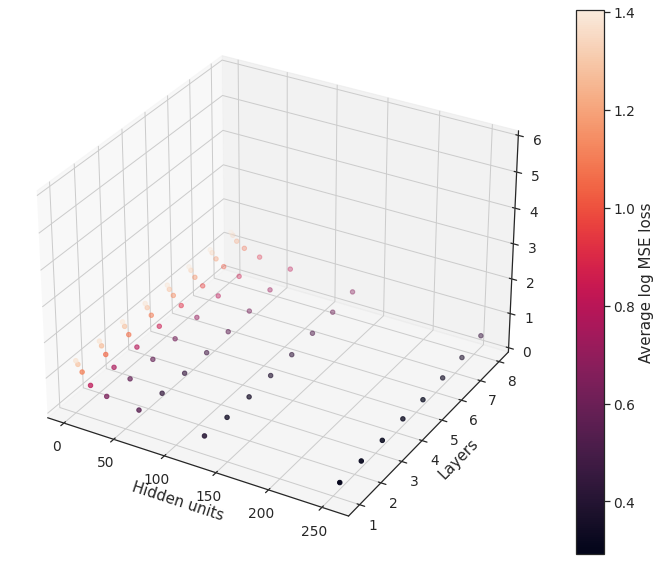

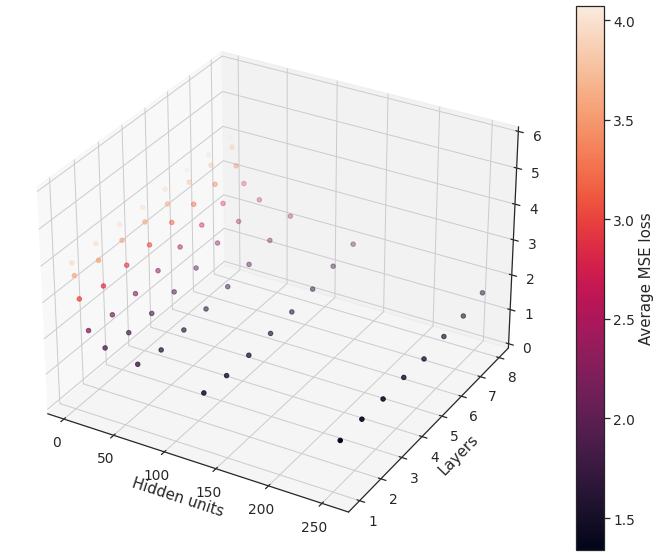

In [15]:
avg_final_eval_loss = torch.load('./temp/complex_mlp_param_search_2.pt')
r, c = find_argmin_in_matrix(avg_final_eval_loss)
print(f'Best hidden unit: {hidden_dims[r]}, best layers: {n_layerss[c]}')
plot_3d_scatter(x=hidden_dims, y=n_layerss, z=np.log(avg_final_eval_loss),
               x_label='Hidden units', y_label='Layers', z_label='Average log MSE loss', fname='complex_mlp_log')
plot_3d_scatter(x=hidden_dims, y=n_layerss, z=avg_final_eval_loss,
               x_label='Hidden units', y_label='Layers', z_label='Average MSE loss', fname='complex_mlp')

##### b) Learning with best parameter

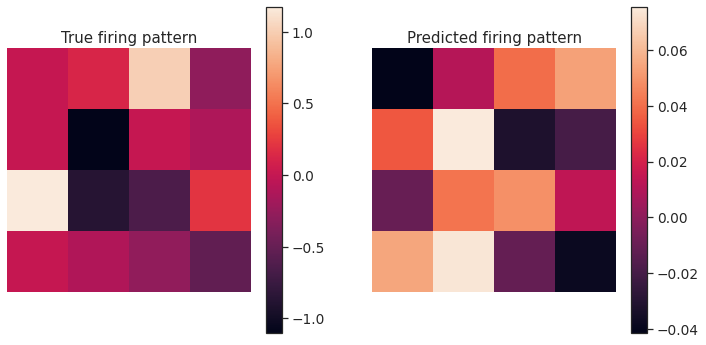

Initial eval loss: 0.7615538120269776
Epoch 1: training loss 0.5894318437576294, eval loss 0.4094598233699799. Time elapsed: 0 h 0 m 0 s.
Epoch 51: training loss 0.23543955773115158, eval loss 0.21397420167922973. Time elapsed: 0 h 0 m 13 s.
Epoch 101: training loss 0.22698339462280273, eval loss 0.22015639543533325. Time elapsed: 0 h 0 m 26 s.
Epoch 151: training loss 0.2052825540304184, eval loss 0.23174958825111389. Time elapsed: 0 h 0 m 39 s.
Epoch 201: training loss 0.18348711997270584, eval loss 0.23102568686008454. Time elapsed: 0 h 0 m 53 s.
Training completed with final epoch loss 8.276119783520699. Time elapsed: 0 h 1 m 6 s.


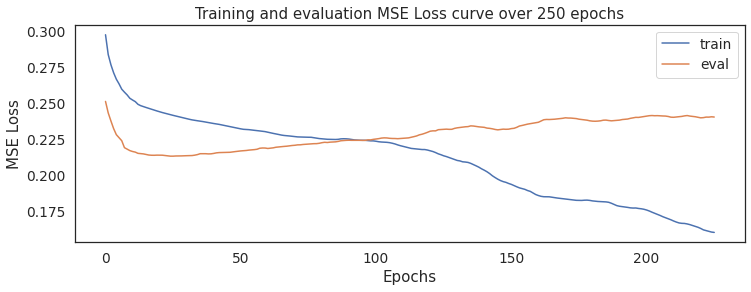

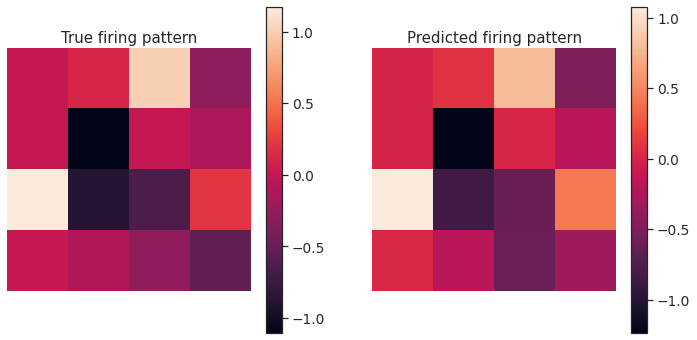

In [4]:
hidden_dim = 256
n_layers = 5


# deep learning model
DNN = FeedForwardDNN(input_dim=16, hidden_dim=hidden_dim, n_layers=n_layers, output_dim=16).to(device)

# training parameters
optimiser = torch.optim.Adam(DNN.parameters(), lr=1e-3)
criterion = nn.MSELoss()

visualise_prediction(Y_test[v_idx,-1,:], DNN(X_test[v_idx,-1,:]), cb=True, fname='viz_complex_mlp_before')

train_losses, eval_losses = train(
    model=DNN,
    train_loader=train_dataloader, test_loader=test_dataloader,
    optimiser=optimiser, criterion=criterion, num_epochs=250,
    verbose=True, force_stop=False)

plot_loss_curves(train_losses, eval_losses, loss_func='MSE Loss', fname='complex_mlp')

visualise_prediction(Y_test[v_idx,-1, :], DNN(X_test[v_idx,-1,:]), cb=True, fname='viz_complex_mlp_after')
torch.save(DNN.state_dict(), f'./dnn_params/complex_mlp_{n_layers}_{hidden_dim}.pt')

##### c) Testing against predicting the mean

In [5]:
print('DNN prediction MSE error on test set:', F.mse_loss(DNN(X_test), Y_test))
print('Predicting mean MSE error on test set', F.mse_loss(torch.mean(Y_test, dim=0).repeat(1000,1,1), Y_test))

DNN prediction MSE error on test set: tensor(0.2349, device='cuda:0', grad_fn=<MseLossBackward0>)
Predicting mean MSE error on test set tensor(0.7593, device='cuda:0')


In [3]:
mses_cpx_mlp = []
n_repeats = 20
for _ in tqdm(range(n_repeats)):
    DNN = FeedForwardDNN(input_dim=16, hidden_dim=256, n_layers=5, output_dim=16).to(device)

    optimiser = torch.optim.Adam(DNN.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    _, _ = train(
        model=DNN,
        train_loader=train_dataloader, test_loader=test_dataloader,
        optimiser=optimiser, criterion=criterion, num_epochs=250,
        verbose=False, force_stop=False)
    mses_cpx_mlp.append(F.mse_loss(DNN(X_test), Y_test).cpu())
    
print(torch.mean(torch.Tensor(mses_cpx_mlp)))
print(torch.std(torch.Tensor(mses_cpx_mlp)))

 95%|█████████▌| 19/20 [23:01<01:12, 72.72s/it]


RuntimeError: CUDA out of memory. Tried to allocate 50.00 MiB (GPU 0; 7.80 GiB total capacity; 5.76 GiB already allocated; 22.56 MiB free; 5.91 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [4]:
print(torch.mean(torch.Tensor(mses_cpx_mlp)))
print(torch.std(torch.Tensor(mses_cpx_mlp)))

tensor(0.2472)
tensor(0.0052)


Output neuron 1: 
 Entropy: 13.11, MSE = 0.000
Output neuron 2: 
 Entropy: 13.05, MSE = 0.800
Output neuron 3: 
 Entropy: 13.11, MSE = 0.152
Output neuron 4: 
 Entropy: 13.11, MSE = 0.099
Output neuron 5: 
 Entropy: 13.11, MSE = 0.020
Output neuron 6: 
 Entropy: 13.11, MSE = 0.150
Output neuron 7: 
 Entropy: 13.11, MSE = 0.081
Output neuron 8: 
 Entropy: 13.00, MSE = 0.675
Output neuron 9: 
 Entropy: 13.11, MSE = 0.154
Output neuron 10: 
 Entropy: 13.04, MSE = 0.116
Output neuron 11: 
 Entropy: 12.97, MSE = 0.180
Output neuron 12: 
 Entropy: 13.11, MSE = 0.283
Output neuron 13: 
 Entropy: 13.11, MSE = 0.069
Output neuron 14: 
 Entropy: 13.05, MSE = 0.584
Output neuron 15: 
 Entropy: 13.11, MSE = 0.227
Output neuron 16: 
 Entropy: 13.11, MSE = 0.161


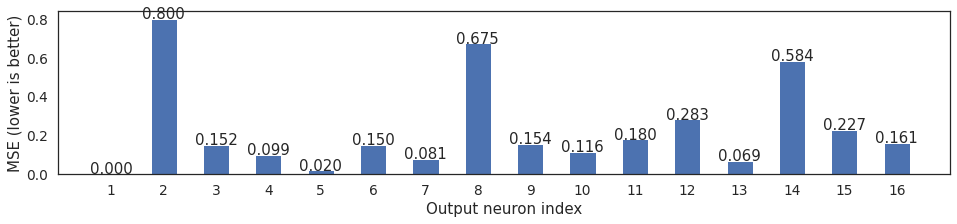

In [3]:
# MSE by output neuron
DNN_params = torch.load(f'./dnn_params/complex_mlp_5_256.pt')
DNN = FeedForwardDNN(input_dim=16, hidden_dim=256, n_layers=5, output_dim=16).to(device)
DNN.load_state_dict(DNN_params)

MSEs = np.zeros(16)
for neuron in range(16):
    MSEs[neuron] = F.mse_loss(DNN(X_test)[:,:,neuron], Y_test[:,:,neuron]).cpu().detach().numpy()
    print(f'Output neuron {neuron+1}: \n Entropy: {str(float(calc_entropy(Y_train[:,:,neuron])))[:5]}, MSE = {str(MSEs[neuron])[:5]}')
plt.figure(figsize=(16,3))
w = 1
plt.bar(np.arange(16), MSEs, 0.5*w)
plt.xticks(np.arange(0, 16), np.arange(1,17))
plt.xlabel('Output neuron index')
plt.ylabel('MSE (lower is better)')
for i in range(16):
    plt.text(i, MSEs[i], str(MSEs[i])[:5], ha='center')

plt.savefig('./figures/complex_mlp_loss_by_neuron', dpi=350, bbox_inches=False)

#### USE RNN

##### a) Parameter search

In [8]:
hidden_dims=[2, 4, 8, 16, 32, 64, 128, 256]
n_layerss=[1, 2, 3, 4, 5, 6, 7, 8]

avg_final_eval_loss = repeated_param_grid_search(
    hidden_dims, n_layerss, n_repeats=30, **{'_type':'RNN', 
                                             'train_loader':train_dataloader, 
                                             'valid_loader':valid_dataloader, 
                                             'test_loader':test_dataloader, 
                                             'n_epochs':n_epochs})
torch.save(avg_final_eval_loss, './temp/complex_lstm_param_search.pt')

Training on:  NVIDIA GeForce RTX 3070 Laptop GPU
1th repeat: best hidden unit: 256, best layers: 8, final eval loss: 1.660589188337326, time elapsed: 0 h 1 m 7 s
2th repeat: best hidden unit: 256, best layers: 7, final eval loss: 1.6781300902366638, time elapsed: 0 h 2 m 24 s
3th repeat: best hidden unit: 256, best layers: 1, final eval loss: 1.654825896024704, time elapsed: 0 h 3 m 43 s
4th repeat: best hidden unit: 256, best layers: 6, final eval loss: 1.6988604664802551, time elapsed: 0 h 5 m 6 s
5th repeat: best hidden unit: 256, best layers: 2, final eval loss: 1.658075749874115, time elapsed: 0 h 6 m 32 s
6th repeat: best hidden unit: 256, best layers: 1, final eval loss: 1.66106316447258, time elapsed: 0 h 7 m 57 s
7th repeat: best hidden unit: 256, best layers: 5, final eval loss: 1.6640718281269073, time elapsed: 0 h 9 m 22 s
8th repeat: best hidden unit: 256, best layers: 4, final eval loss: 1.659622311592102, time elapsed: 0 h 10 m 46 s
9th repeat: best hidden unit: 256, bes

Best hidden unit: 256, best layers: 8


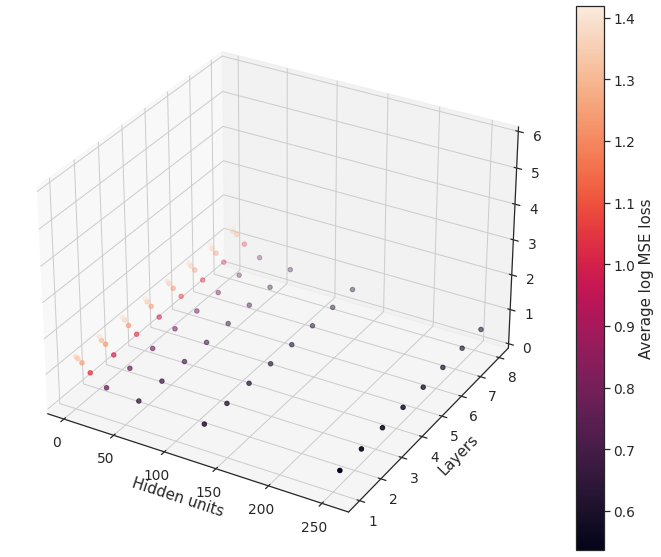

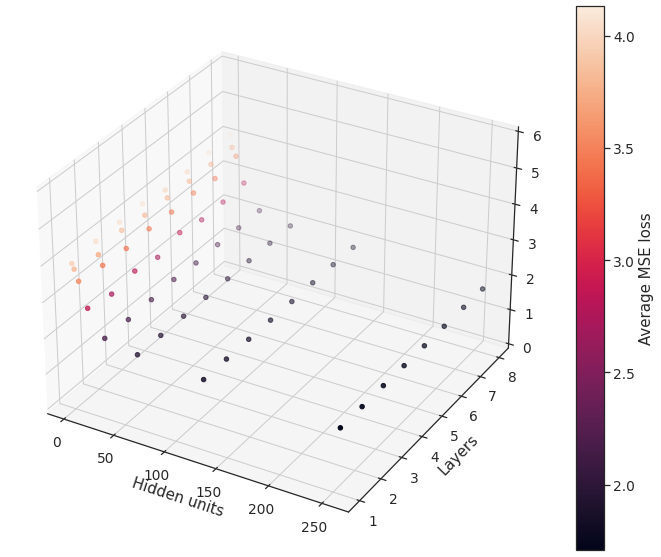

In [16]:
avg_final_eval_loss = torch.load('./temp/complex_lstm_param_search.pt')
r, c = find_argmin_in_matrix(avg_final_eval_loss)
print(f'Best hidden unit: {hidden_dims[r]}, best layers: {n_layerss[c]}')
plot_3d_scatter(x=hidden_dims, y=n_layerss, z=np.log(avg_final_eval_loss),
               x_label='Hidden units', y_label='Layers', z_label='Average log MSE loss', fname='complex_lstm_log')
plot_3d_scatter(x=hidden_dims, y=n_layerss, z=avg_final_eval_loss,
               x_label='Hidden units', y_label='Layers', z_label='Average MSE loss', fname='complex_lstm')

##### b) Learning with best parameter

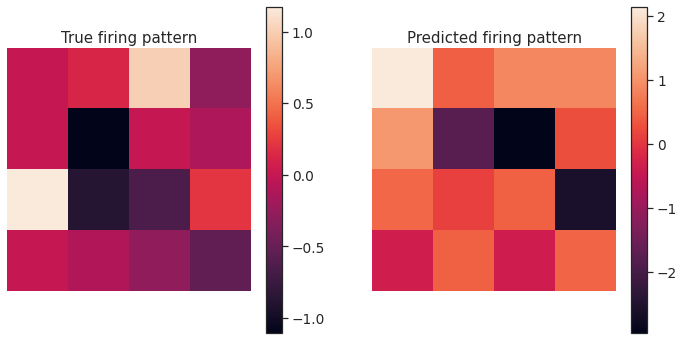

Initial eval loss: 2.3949883460998533
Epoch 1: training loss 0.7759468710422516, eval loss 0.43774646520614624. Time elapsed: 0 h 0 m 0 s.
Epoch 51: training loss 0.27640812903642653, eval loss 0.23530454635620118. Time elapsed: 0 h 0 m 15 s.
Epoch 101: training loss 0.27124940663576125, eval loss 0.23128503262996675. Time elapsed: 0 h 0 m 31 s.
Epoch 151: training loss 0.26874107658863067, eval loss 0.22915322184562684. Time elapsed: 0 h 0 m 47 s.
Epoch 201: training loss 0.26680219382047654, eval loss 0.22767869234085084. Time elapsed: 0 h 1 m 3 s.
Epoch 251: training loss 0.26535133123397825, eval loss 0.22619110643863677. Time elapsed: 0 h 1 m 18 s.
Epoch 301: training loss 0.2642585289478302, eval loss 0.22509102523326874. Time elapsed: 0 h 1 m 34 s.
Epoch 351: training loss 0.2633956405520439, eval loss 0.22429363131523133. Time elapsed: 0 h 1 m 50 s.
Epoch 401: training loss 0.2626836323738098, eval loss 0.22364655137062073. Time elapsed: 0 h 2 m 5 s.
Epoch 451: training loss 0.

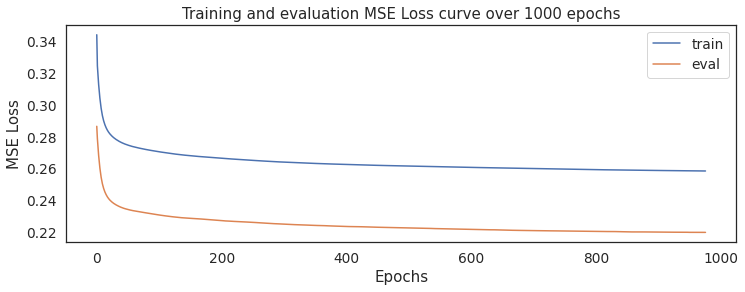

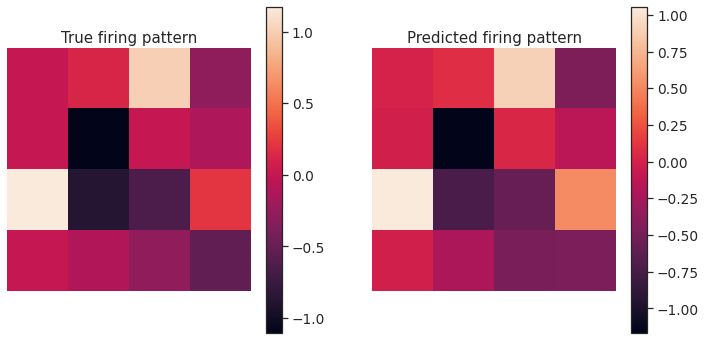

In [5]:
hidden_dim = 256
n_linear_layers = 8

# deep learning model
DNN = RecurrentDNN(input_dim=16, hidden_dim=256, n_linear_layers=n_linear_layers, output_dim=16, n_lstm_layers=1).to(device)

# training parameters
optimiser = torch.optim.Adam(DNN.parameters(), lr=1e-3)
criterion = nn.MSELoss()

_, Y_hats = eval_rnn(DNN, test_dataloader, criterion, save_Y_hat=True)

visualise_prediction(Y_test[v_idx,-1,:], Y_hats[v_idx,-1,:], cb=True, fname='viz_complex_rnn_before')

train_losses, eval_losses = train_rnn(
    model=DNN,
    train_loader=train_dataloader, test_loader=test_dataloader,
    optimiser=optimiser, criterion=criterion, num_epochs=1000,
    verbose=True, force_stop=False)

plot_loss_curves(train_losses, eval_losses, loss_func='MSE Loss', fname='train_curve_complex_rnn')

_, Y_hats = eval_rnn(DNN, test_dataloader, criterion, save_Y_hat=True)
visualise_prediction(Y_test[v_idx,-1,:], Y_hats[v_idx,-1,:], cb=True, fname='viz_complex_rnn_after')

torch.save(DNN.state_dict(), f'./dnn_params/complex_lstm_{n_linear_layers}_{hidden_dim}.pt')

##### c) Testing against predicting the mean

In [4]:
print('DNN prediction MSE error on test set:', F.mse_loss(Y_hats, Y_test))
print('Predicting mean MSE error on test set', F.mse_loss(torch.mean(Y_test, dim=0).repeat([1000,1,1]), Y_test))

DNN prediction MSE error on test set: tensor(0.2186, device='cuda:0')
Predicting mean MSE error on test set tensor(0.7593, device='cuda:0')


  0%|          | 0/20 [00:00<?, ?it/s]

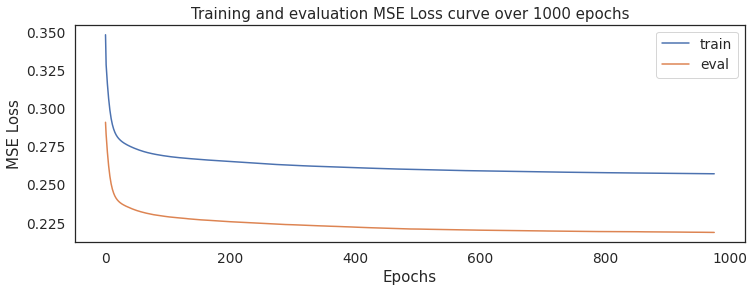

  5%|▌         | 1/20 [04:58<1:34:23, 298.09s/it]

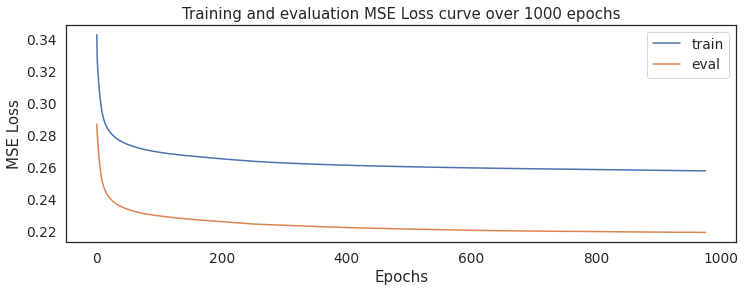

 10%|█         | 2/20 [09:58<1:29:53, 299.64s/it]

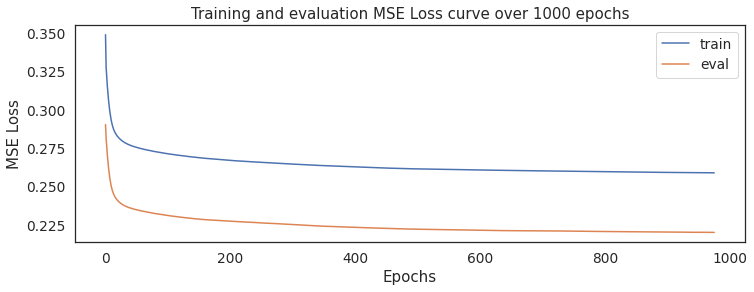

 15%|█▌        | 3/20 [14:58<1:24:53, 299.59s/it]

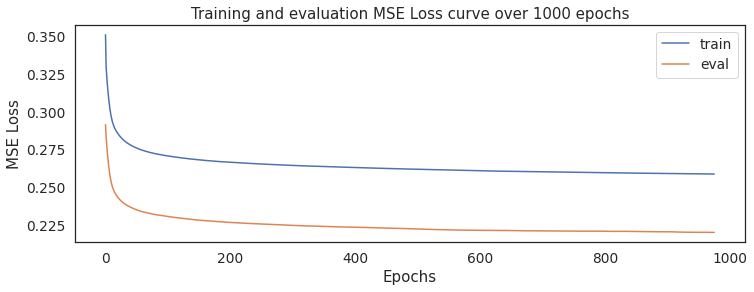

 20%|██        | 4/20 [19:59<1:20:00, 300.04s/it]

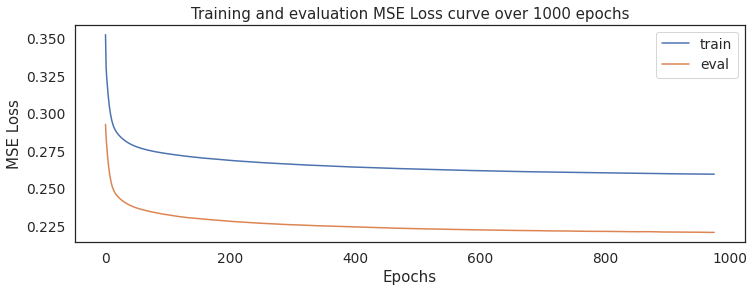

 25%|██▌       | 5/20 [24:59<1:15:01, 300.10s/it]

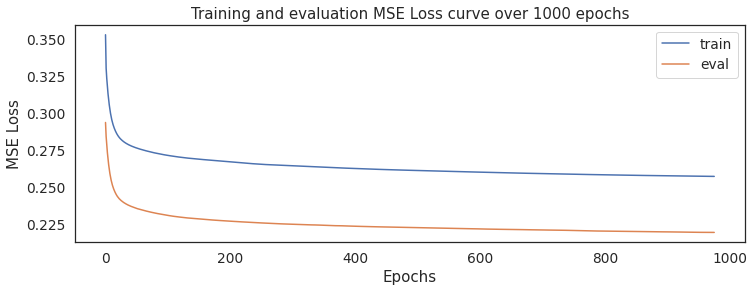

 30%|███       | 6/20 [29:59<1:10:04, 300.29s/it]

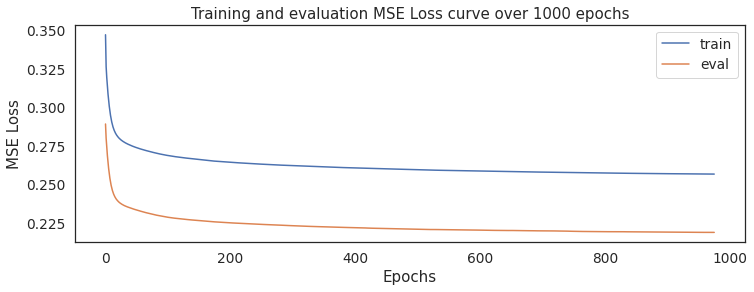

 35%|███▌      | 7/20 [34:59<1:05:01, 300.11s/it]

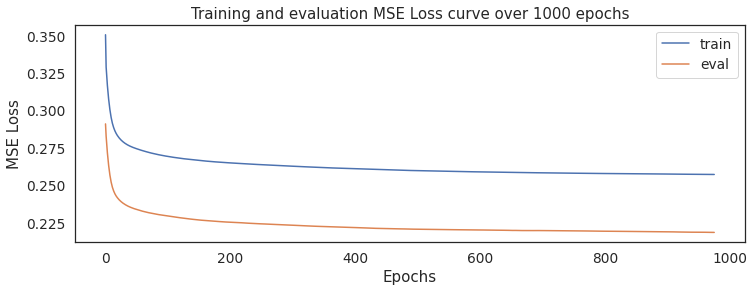

 40%|████      | 8/20 [40:00<1:00:04, 300.37s/it]

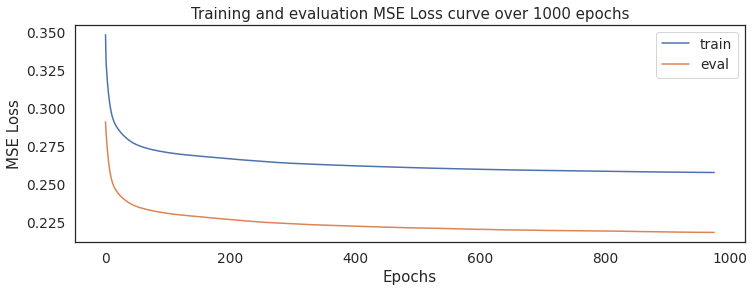

 45%|████▌     | 9/20 [45:00<55:01, 300.16s/it]  

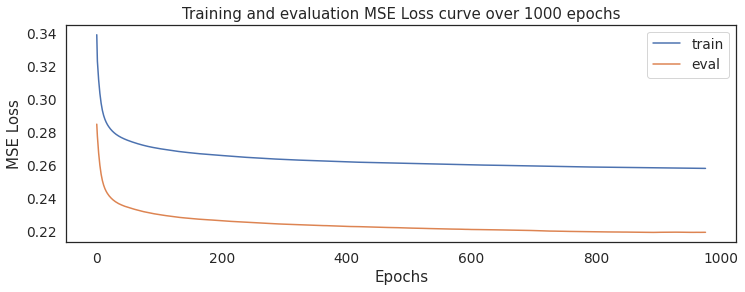

 50%|█████     | 10/20 [50:01<50:06, 300.61s/it]

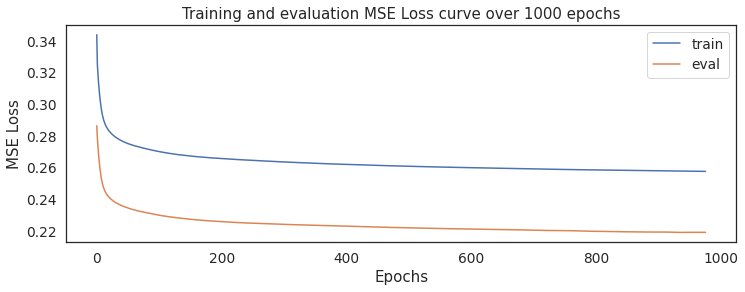

 55%|█████▌    | 11/20 [55:01<45:02, 300.33s/it]

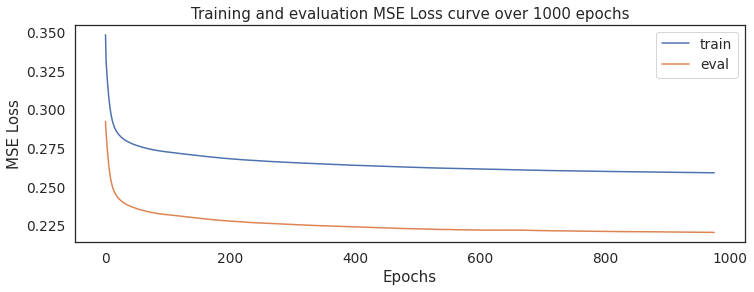

 60%|██████    | 12/20 [1:00:02<40:03, 300.39s/it]

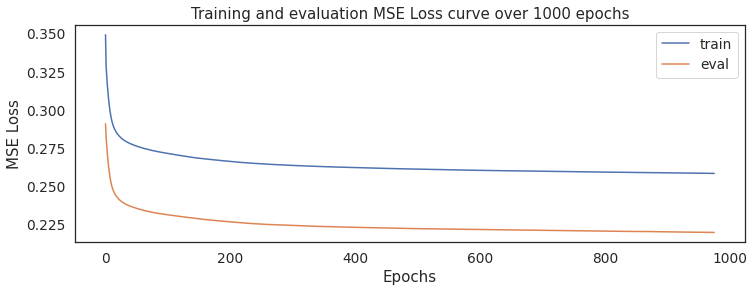

 65%|██████▌   | 13/20 [1:05:02<35:03, 300.52s/it]

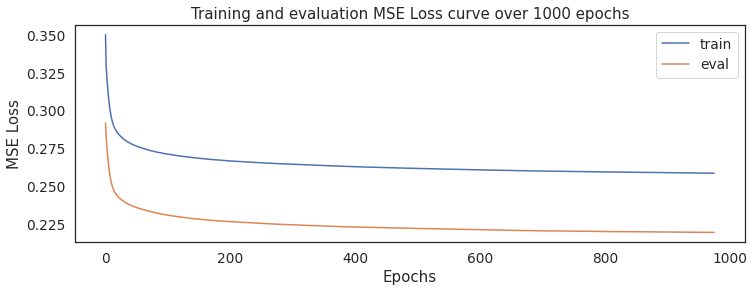

 70%|███████   | 14/20 [1:10:09<30:14, 302.41s/it]

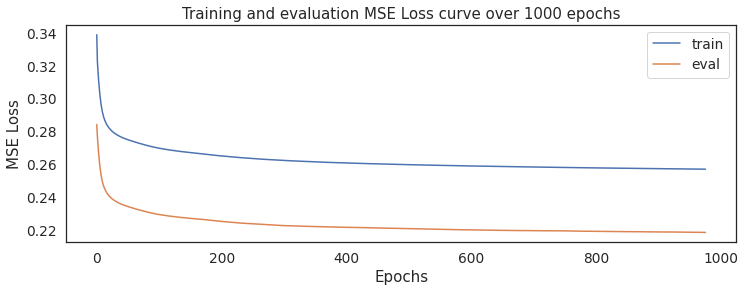

 75%|███████▌  | 15/20 [1:15:22<25:27, 305.47s/it]

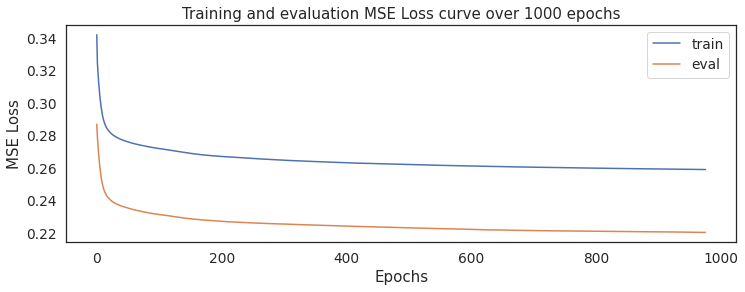

 80%|████████  | 16/20 [1:20:29<20:24, 306.14s/it]

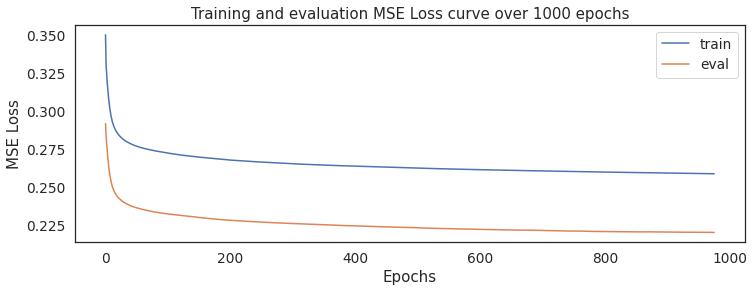

 85%|████████▌ | 17/20 [1:25:46<15:27, 309.26s/it]

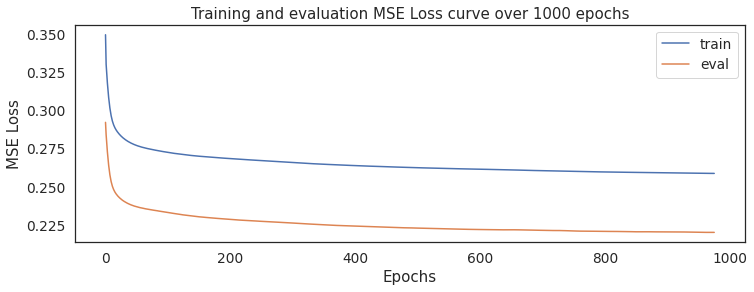

 90%|█████████ | 18/20 [1:30:55<10:18, 309.15s/it]

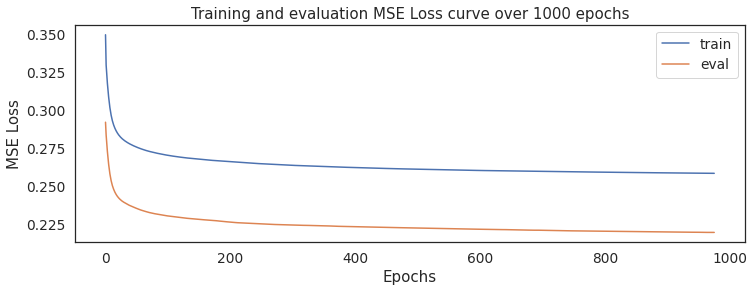

 95%|█████████▌| 19/20 [1:36:08<05:10, 310.39s/it]

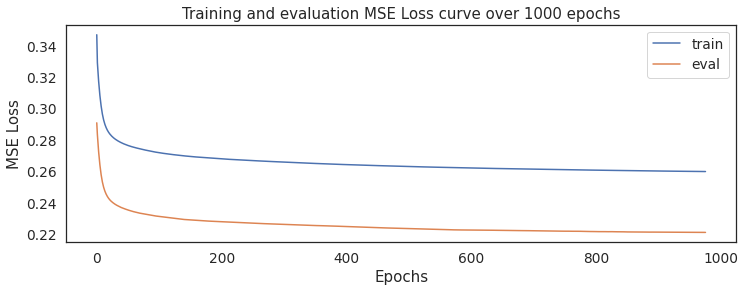

100%|██████████| 20/20 [1:41:25<00:00, 304.25s/it]

tensor(0.2196)
tensor(0.0008)


In [3]:
mses_cpx_rnn = []
n_repeats = 20
for _ in tqdm(range(n_repeats)):
    DNN = RecurrentDNN(input_dim=16, hidden_dim=256, n_linear_layers=8, output_dim=16, n_lstm_layers=1).to(device)

    optimiser = torch.optim.Adam(DNN.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    train_losses, eval_losses = train_rnn(
        model=DNN,
        train_loader=train_dataloader, test_loader=test_dataloader,
        optimiser=optimiser, criterion=criterion, num_epochs=1000,
        verbose=False, force_stop=False)

    _, Y_hats = eval_rnn(DNN, test_dataloader, criterion, save_Y_hat=True)
    mses_cpx_rnn.append(F.mse_loss(Y_hats, Y_test).cpu()) 
    
print(torch.mean(torch.Tensor(mses_cpx_rnn)))
print(torch.std(torch.Tensor(mses_cpx_rnn)))

Output neuron 1: 
 Entropy: 13.11, MSE = 0.000
Output neuron 2: 
 Entropy: 13.05, MSE = 0.683
Output neuron 3: 
 Entropy: 13.11, MSE = 0.130
Output neuron 4: 
 Entropy: 13.11, MSE = 0.096
Output neuron 5: 
 Entropy: 13.11, MSE = 0.020
Output neuron 6: 
 Entropy: 13.11, MSE = 0.140
Output neuron 7: 
 Entropy: 13.11, MSE = 0.077
Output neuron 8: 
 Entropy: 13.00, MSE = 0.651
Output neuron 9: 
 Entropy: 13.11, MSE = 0.134
Output neuron 10: 
 Entropy: 13.04, MSE = 0.118
Output neuron 11: 
 Entropy: 12.97, MSE = 0.193
Output neuron 12: 
 Entropy: 13.11, MSE = 0.258
Output neuron 13: 
 Entropy: 13.11, MSE = 0.060
Output neuron 14: 
 Entropy: 13.05, MSE = 0.555
Output neuron 15: 
 Entropy: 13.11, MSE = 0.228
Output neuron 16: 
 Entropy: 13.11, MSE = 0.162


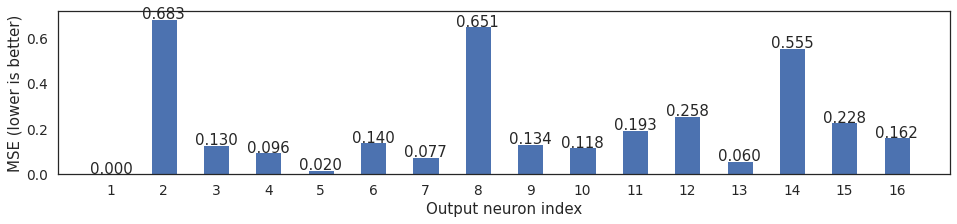

In [9]:
# MSE by output neuron
DNN_params = torch.load(f'./dnn_params/complex_lstm_5_256.pt')
DNN = RecurrentDNN(input_dim=16, hidden_dim=256, n_linear_layers=5, output_dim=16).to(device)
DNN.load_state_dict(DNN_params)
criterion = nn.MSELoss()

_, Y_hats = eval_rnn(DNN, test_dataloader, criterion, save_Y_hat=True)

Y_hats, Y_test = Y_hats.view(-1, 16), Y_test.view(-1,16)
MSEs = np.zeros(16)
for neuron in range(16):
    MSEs[neuron] = F.mse_loss(Y_hats[:,neuron], Y_test[:, neuron]).cpu().numpy()
    print(f'Output neuron {neuron+1}: \n Entropy: {str(float(calc_entropy(Y_train[:,:,neuron])))[:5]}, MSE = {str(MSEs[neuron])[:5]}')
plt.figure(figsize=(16,3))
w = 1
plt.bar(np.arange(16), MSEs, 0.5*w)
plt.xticks(np.arange(0, 16), np.arange(1,17))
plt.xlabel('Output neuron index')
plt.ylabel('MSE (lower is better)')
for i in range(16):
    plt.text(i, MSEs[i], str(MSEs[i])[:5], ha='center')

plt.savefig('./figures/complex_rnn_loss_by_neuron', dpi=350, bbox_inches=False)
plt.show()

## Complexity of DNN vs Data Efficiency
What is the least complex DNN that does a good job of mimicking the approximate the complexBNN?

In [3]:
X_train, Y_train = load_data('./data/', 'complex_train.pkl')
X_test, Y_test = load_data('./data/', 'complex_test.pkl')
X_valid, Y_valid = load_data('./data/', 'complex_valid.pkl')

hidden_dims=[2, 4, 8, 16, 32, 64, 128, 256]
n_layerss=[1, 2, 3, 4, 5, 6, 7, 8]

n_datas = [1, 5, 10, 50, 100, 200, 400, 800, 1600, 3200, 6400]   # number of train data used, from 1 to len(X_train)

In [7]:
train_dataset = BNN_Dataset(X_train, Y_train)

test_dataset = BNN_Dataset(X_test, Y_test)
test_dataloader = DataLoader(test_dataset, batch_size=200, shuffle=False)

In [4]:
avg_final_eval_losses = repeated_complexity_varying_data_efficiency(
    hidden_dims=hidden_dims, n_layerss=n_layerss, n_repeats=1, verbose=True,
    **{'input_dim':16,
       'output_dim':16,
       'train_dataset':train_dataset, 
       'test_dataloader':test_dataloader,
       'n_datas':n_datas,
       'n_epochs':50,
       'type':'MLP'})
torch.save(avg_final_eval_losses, './temp/avg_final_eval_loss_f_50.pt')

1 of 1 repeats. Time elapsed: time elapsed: 0 h 29 m 59 snts.


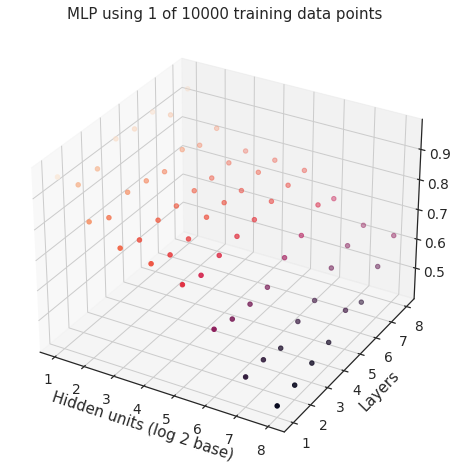

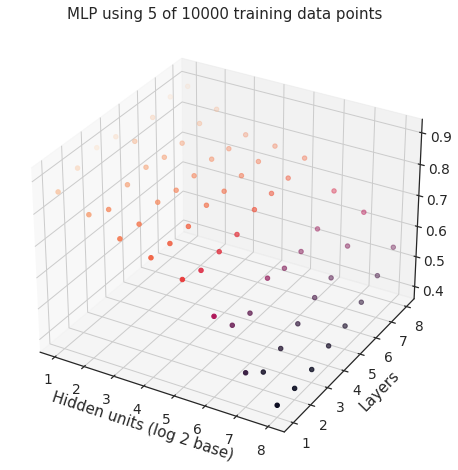

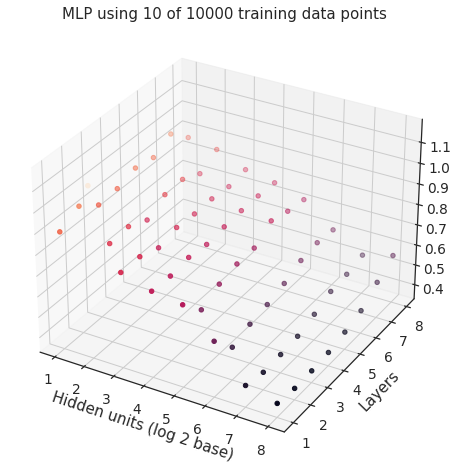

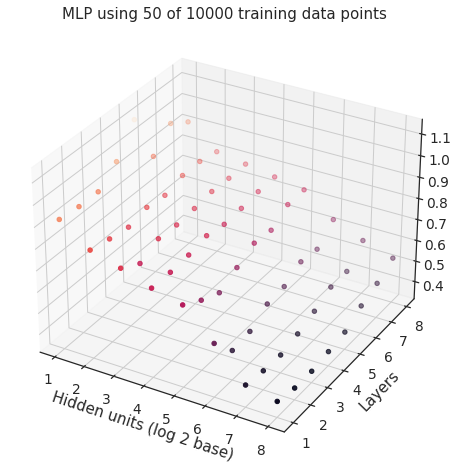

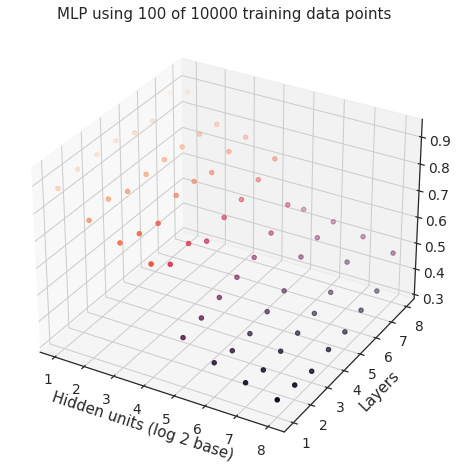

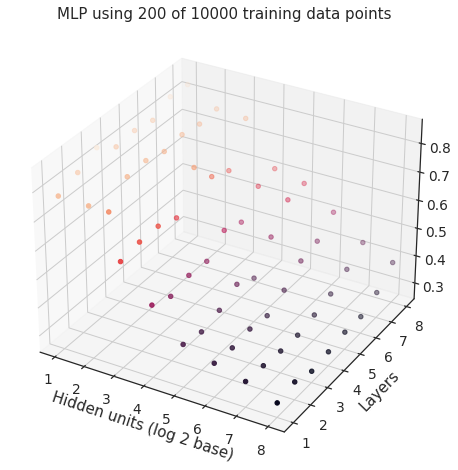

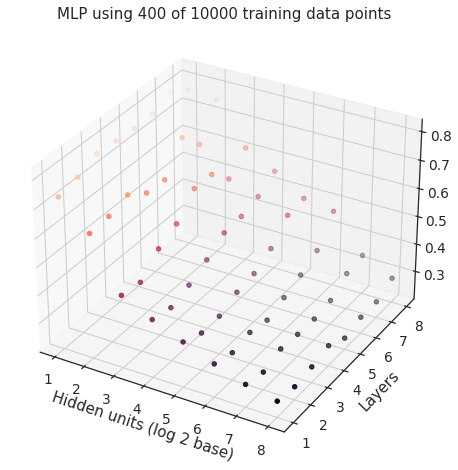

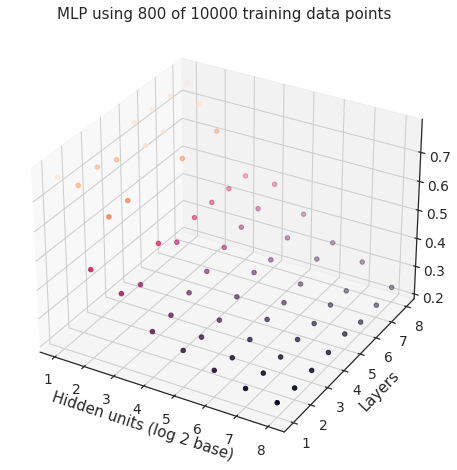

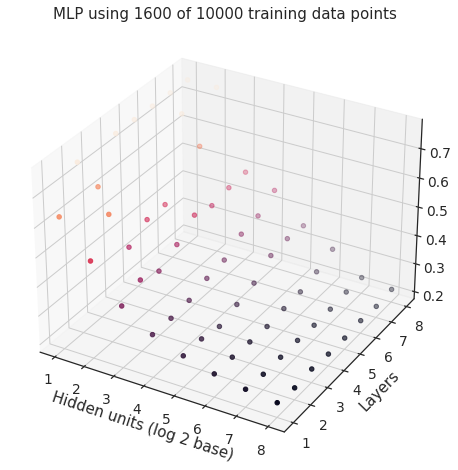

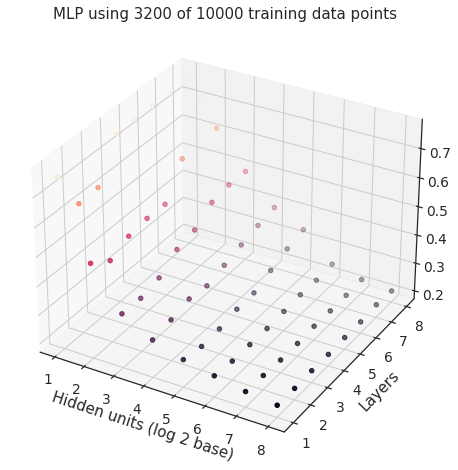

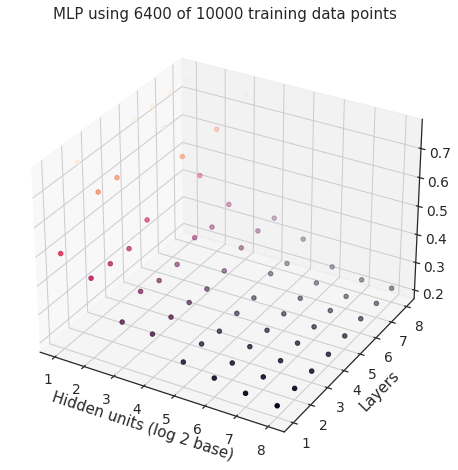

In [4]:
avg_final_eval_losses = torch.load('./temp/avg_final_eval_loss_f_50.pt')
for i, n_data in enumerate(n_datas):
    plot_3d_scatter(x=np.log2(hidden_dims), y=n_layerss, z=avg_final_eval_losses[:,:,i],
                    x_label='Hidden units (log 2 base)', y_label='Layers', z_label= f'Test set MSE loss for {n_data} training data', colorbar=False,
                    fname=f'data_efficiency_mlp_{n_data}', title=f'MLP using {n_data} of 10000 training data points', figsize=(10,8))

#### RNN

In [3]:
X_train, Y_train = load_data('./data/', 'complex_train.pkl')
X_test, Y_test = load_data('./data/', 'complex_test.pkl')
X_valid, Y_valid = load_data('./data/', 'complex_valid.pkl')

hidden_dims=[2, 4, 8, 16, 32, 64, 128, 256]
n_layerss=[1, 2, 3, 4, 5, 6, 7, 8]

batch_size = 200                            # number of data points in each mini-batch
n_datas = [1, 5, 10, 50, 100, 200, 400, 800, 1600, 3200, 6400]  # number of train data used, from 1 to len(X_train)
n_epochs = 150                               # number of training epochs

In [6]:
train_dataset = BNN_Dataset(X_train, Y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

test_dataset = BNN_Dataset(X_test, Y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

valid_dataset = BNN_Dataset(X_valid, Y_valid)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [19]:
avg_final_eval_losses = repeated_complexity_varying_data_efficiency(
    hidden_dims=hidden_dims, n_layerss=n_layerss, n_repeats=1, verbose=True,
    **{'input_dim':16,
       'output_dim':16,
       'train_dataset':train_dataset, 
       'test_dataloader':test_dataloader,
       'n_datas':n_datas,
       'n_epochs':500,
       'type':'RNN'})
torch.save(avg_final_eval_losses, './temp/avg_final_eval_loss_rnn_500.pt')

Training on:  NVIDIA GeForce RTX 3070 Laptop GPU
1 of 1 repeats. Time elapsed: time elapsed: 3 h 7 m 23 sints.


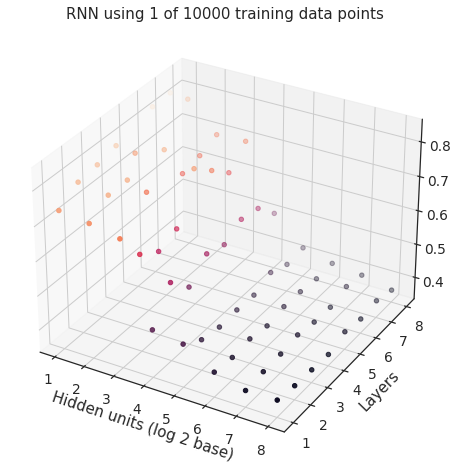

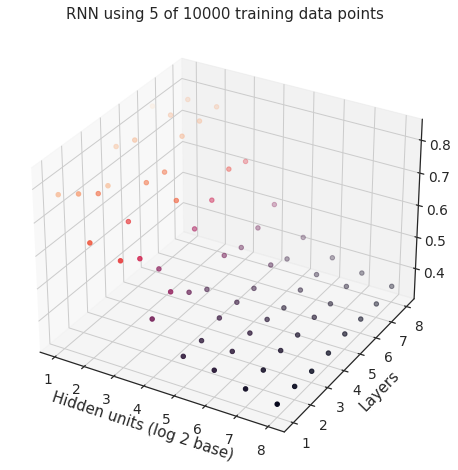

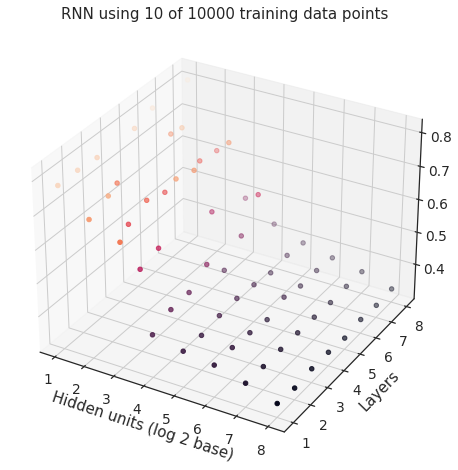

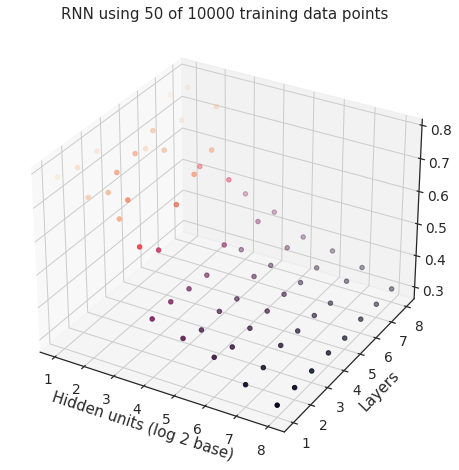

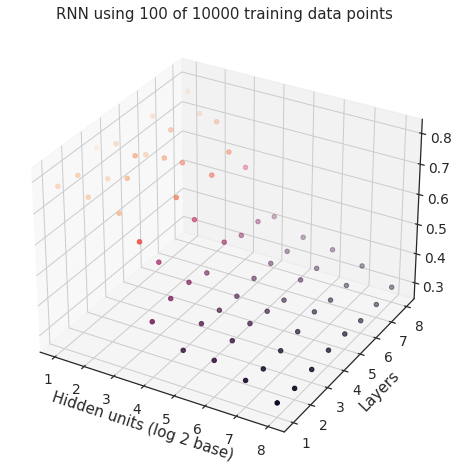

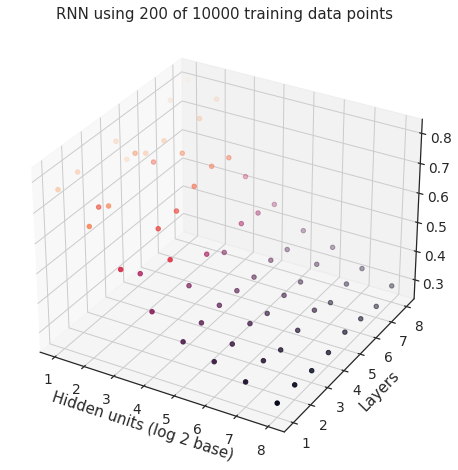

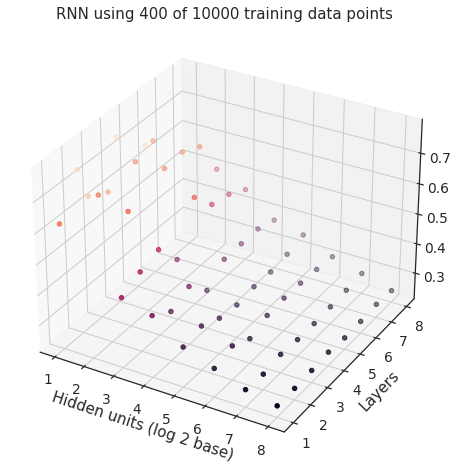

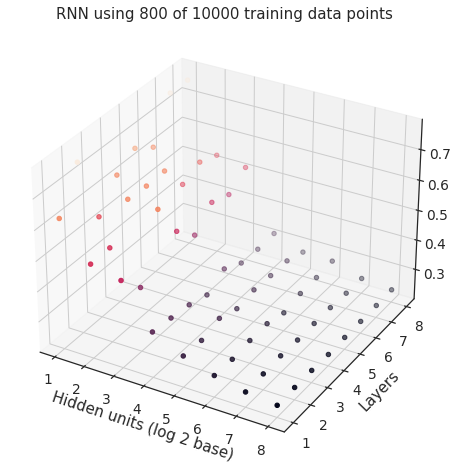

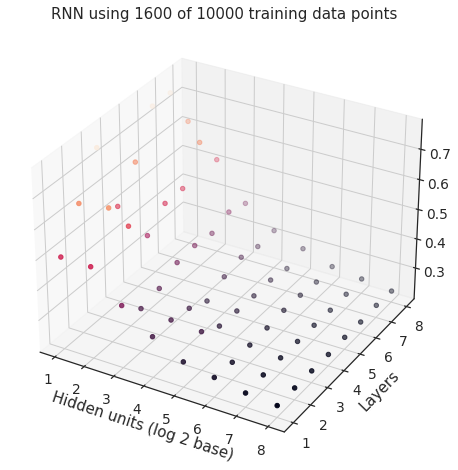

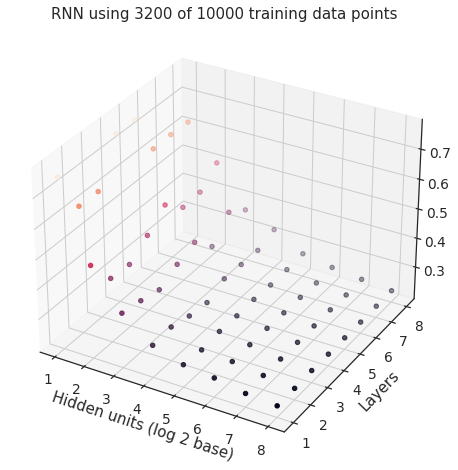

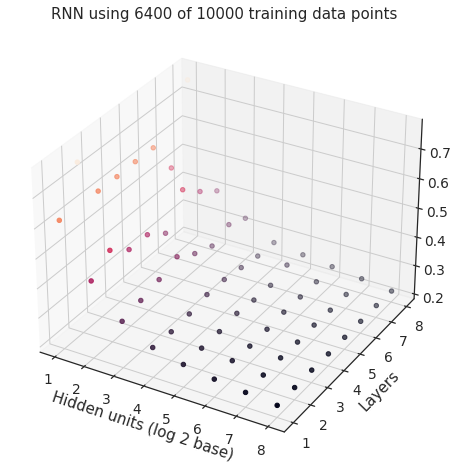

In [20]:
avg_final_eval_losses = torch.load('./temp/avg_final_eval_loss_rnn_500.pt')
for i, n_data in enumerate(n_datas):
    plot_3d_scatter(x=np.log2(hidden_dims), y=n_layerss, z=avg_final_eval_losses[:,:,i],
                    x_label='Hidden units (log 2 base)', y_label='Layers', z_label= f'Test set MSE loss for {n_data} training data', colorbar=False,
                    fname=f'data_efficiency_rnn_{n_data}', title=f'RNN using {n_data} of 10000 training data points', figsize=(10,8))

In [7]:
avg_final_eval_losses_rnn = torch.load('./temp/avg_final_eval_loss_rnn_500.pt')
avg_final_eval_losses_mlp = torch.load('./temp/avg_final_eval_loss_f_50.pt')

mean_mlp = 0
mean_rnn = 0
for _ in range(30):
    DNN1 = FeedForwardDNN(16,256, 5, 16).to(device)
    DNN2 = RecurrentDNN(16, 256, 8, 16, 1).to(device)
    mean_mlp += eval(DNN1, test_dataloader, nn.MSELoss())
    mean_rnn += eval_rnn(DNN2, test_dataloader, nn.MSELoss())
mean_mlp /= 30
mean_rnn /= 30

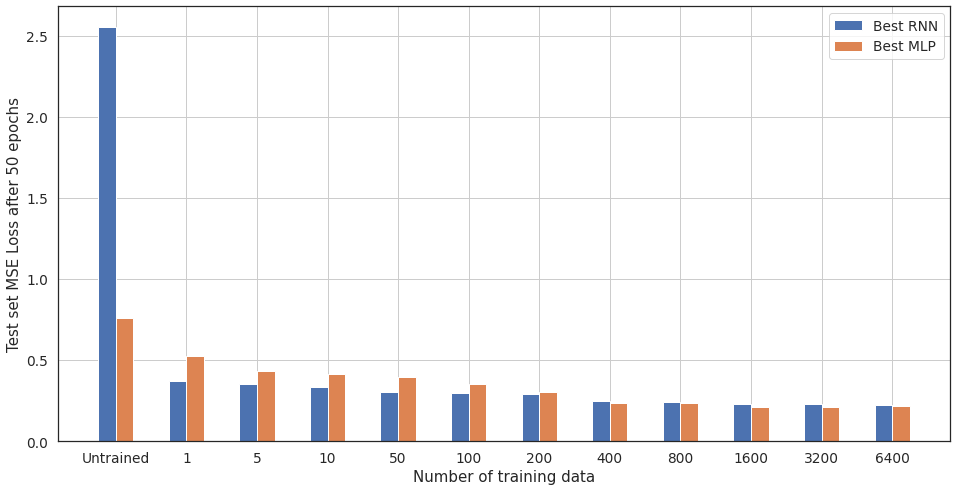

In [23]:
n_datas = ['Untrained', 1, 5, 10, 50, 100, 200, 400, 800, 1600, 3200, 6400]
# bar plot
width = 0.5
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(np.arange(12) - width*1/4, torch.concat((torch.Tensor([mean_rnn]), avg_final_eval_losses_rnn[7,7,:])), width/2, label='Best RNN')
ax.bar(np.arange(12) + width*1/4, torch.concat((torch.Tensor([mean_mlp]), avg_final_eval_losses_mlp[7,4,:])), width/2, label='Best MLP')
plt.xlabel('Number of training data')
plt.ylabel('Test set MSE Loss after 50 epochs')
plt.legend()
plt.xticks(np.arange(len(n_datas)), n_datas)
plt.grid()
plt.show()

NameError: name 'avg_final_eval_losses_rnn' is not defined

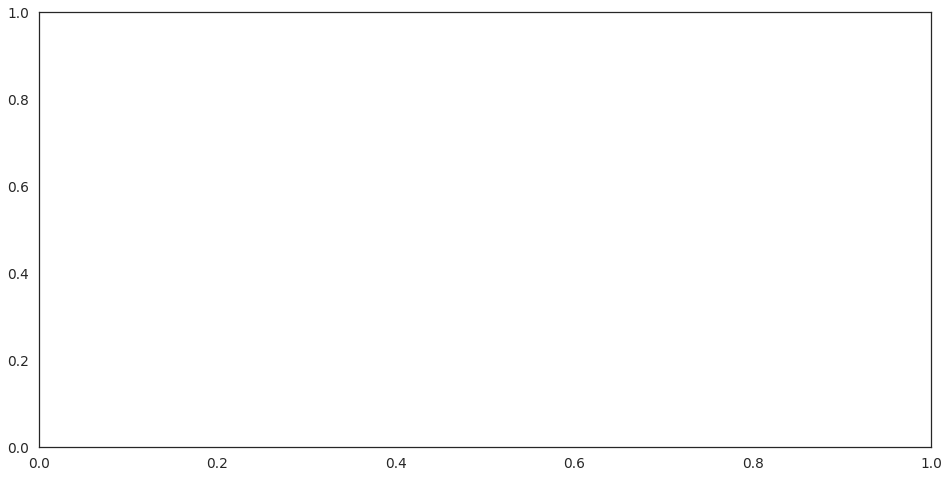

In [4]:
n_datas = [1, 5, 10, 50, 100, 200, 400, 800, 1600, 3200, 6400]
# bar plot
width = 0.5
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(np.arange(11) - width*1/4, avg_final_eval_losses_rnn[7,7,:], width/2, label='Best RNN')
ax.bar(np.arange(11) + width*1/4, avg_final_eval_losses_mlp[7,4,:], width/2, label='Best MLP')
plt.xlabel('Number of training data vectors (each contains 50 steps)')
plt.ylabel('Test set MSE Loss after 1000 epochs')
plt.legend()
plt.xticks(np.arange(len(n_datas)), n_datas)
plt.grid()
plt.savefig('./figures/data_efficiency_comparison', dpi=350, bbox_inches='tight')
plt.show()

## BNN Plasticity analysis
We explore to what extent pre-training of a DNN helps when the plasticity of the approximate BNN is changed slightly (according to a Gaussian)

In [2]:
from approx_bnns import ComplexApproximateBNN

# BNN params
x, y, z = 256, 0.5, 4
bias = True
trainable = False
residual_in = [False, False, 1, 2]

input_dim = 16
output_dim = 16
batch_size = 200
transfer_functions=[nn.ReLU(), nn.ELU(), nn.SiLU(), nn.CELU(), nn.Tanh(), nn.Sigmoid(), nn.LeakyReLU(0.1), nn.LeakyReLU(0.2), nn.LeakyReLU(0.3)]

# initialise BNN, and load original weights
approx_bnn = ComplexApproximateBNN(
    x=x, y=y, z=z, 
    input_dim=input_dim, 
    output_dim=output_dim, 
    residual_in=residual_in, 
    recurrent_dim=-1, 
    transfer_functions=transfer_functions
).to(device)

BNN_weights = torch.load('./approx_bnn_params/complex.pt')
BNN_non_linearities = load_non_linearities('./approx_bnn_params/complex_activations.pkl')
approx_bnn.load_state_dict(BNN_weights)
approx_bnn.load_non_linearities(BNN_non_linearities)

# fixing input pattern
X_train, _ = load_data('./data/', 'complex_train.pkl')
X_test, _ = load_data('./data/', 'complex_test.pkl')
X_valid, _ = load_data('./data/', 'complex_valid.pkl')

In [3]:
# initialise DNN
hidden_dim = 256
n_layers = 8
DNN_params = torch.load(f'./dnn_params/complex_lstm_8_256.pt')
DNN = RecurrentDNN(input_dim=16, hidden_dim=hidden_dim, n_linear_layers=n_layers, output_dim=16).to(device)
DNN.load_state_dict(DNN_params)

<All keys matched successfully>

In [4]:
sigmas = torch.exp(torch.linspace(-6, 1, 9))
num_epochs = 15
params = {'DNN': DNN,
          'BNN': approx_bnn, 
          'DNN_params': DNN_params, 
          'BNN_params': (BNN_weights, BNN_non_linearities), 
          'sigmas': sigmas, 
          'batch_size': batch_size,
          'num_epochs': num_epochs,
          'X_train': X_train, 
          'X_test': X_test,
          'verbose': 0}

In [5]:
mean_transfer, std_transfer = repeated_plasticity_analysis(n_repeats=25, transfer_learning=True, **params)
mean_retrain, std_retrain = repeated_plasticity_analysis(n_repeats=25, transfer_learning=False, **params)

train_losses_by_sigma_transfer, eval_losses_by_sigma_transfer, init_losses_by_sigma_transfer = mean_transfer
train_losses_by_sigma_reset, eval_losses_by_sigma_reset, init_losses_by_sigma_reset = mean_retrain

Training on:  NVIDIA GeForce RTX 3070 Laptop GPU
Repeat 1/25
Repeat 2/25
Repeat 3/25
Repeat 4/25
Repeat 5/25
Repeat 6/25
Repeat 7/25
Repeat 8/25
Repeat 9/25
Repeat 10/25
Repeat 11/25
Repeat 12/25
Repeat 13/25
Repeat 14/25
Repeat 15/25
Repeat 16/25
Repeat 17/25
Repeat 18/25
Repeat 19/25
Repeat 20/25
Repeat 21/25
Repeat 22/25
Repeat 23/25
Repeat 24/25
Repeat 25/25
Training on:  NVIDIA GeForce RTX 3070 Laptop GPU
Repeat 1/25
Repeat 2/25
Repeat 3/25
Repeat 4/25
Repeat 5/25
Repeat 6/25
Repeat 7/25
Repeat 8/25
Repeat 9/25
Repeat 10/25
Repeat 11/25
Repeat 12/25
Repeat 13/25
Repeat 14/25
Repeat 15/25
Repeat 16/25
Repeat 17/25
Repeat 18/25
Repeat 19/25
Repeat 20/25
Repeat 21/25
Repeat 22/25
Repeat 23/25
Repeat 24/25
Repeat 25/25


In [6]:
torch.save((mean_transfer, std_transfer), './temp/RNN_plasticity_transfer_sep.pt')
torch.save((mean_retrain, std_retrain), './temp/RNN_plasticity_retrain_sep.pt')

In [7]:
(mean_transfer, std_transfer) = torch.load('./temp/RNN_plasticity_transfer_n.pt')
(mean_retrain, std_retrain) = torch.load('./temp/RNN_plasticity_retrain_n.pt')
train_losses_by_sigma_transfer, eval_losses_by_sigma_transfer, init_losses_by_sigma_transfer = mean_transfer
train_losses_by_sigma_reset, eval_losses_by_sigma_reset, init_losses_by_sigma_reset = mean_retrain

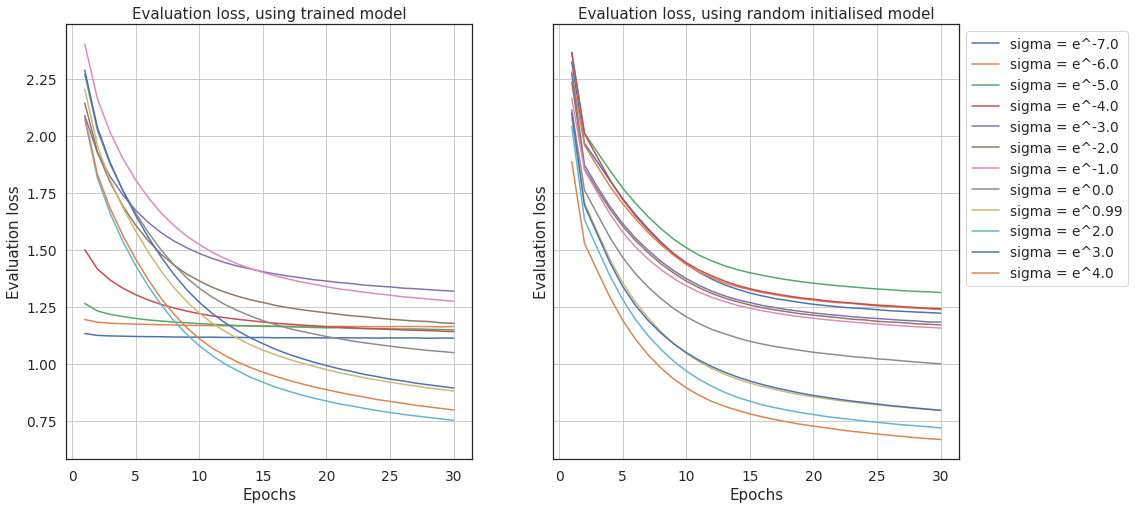

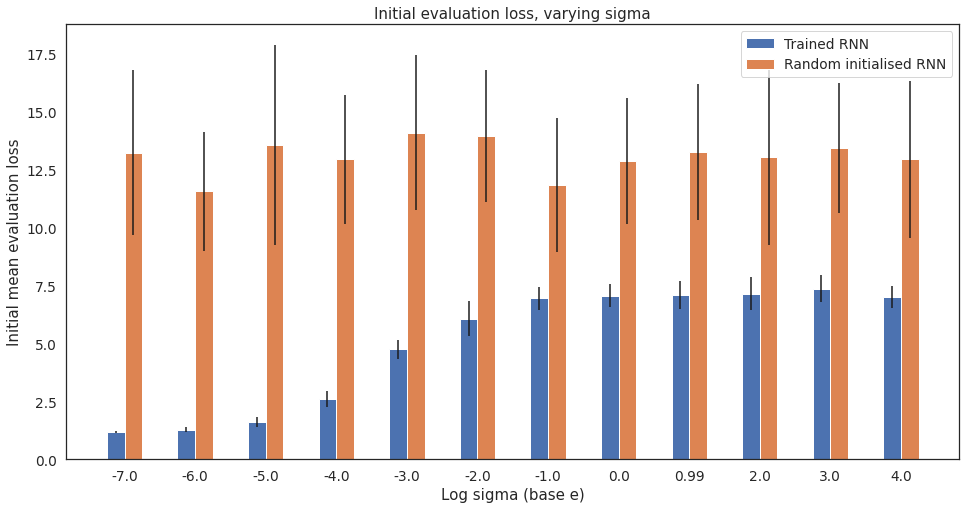

In [12]:
(mean_transfer, std_transfer) = torch.load( './temp/RNN_plasticity_transfer_n.pt')
(mean_retrain, std_retrain) = torch.load( './temp/RNN_plasticity_retrain_n.pt')


# normal scale loss
n_sigma = sigmas.shape[0]

f, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(16,8))
plt.subplot(121)
plt.title('Evaluation loss, using trained model')
n_sigmas = len(sigmas)
for i in range(n_sigma): # for each sigma
    ax1.plot(np.arange(1, num_epochs+1),
             mean_transfer[1][i,:],
             # yerr=std_transfer[1][i,:],
             label=f'sigma = e^{str(torch.log(sigmas[i]).cpu().numpy())[:4]}')
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Evaluation loss')

plt.subplot(122)
plt.title('Evaluation loss, using random initialised model')
for i in range(train_losses_by_sigma_transfer.shape[0]):
    ax2.plot(np.arange(1, num_epochs+1),
             mean_retrain[1][i,:], 
             # yerr=std_retrain[1][i,:], 
             label=f'sigma = e^{str(torch.log(sigmas[i]).cpu().numpy())[:4]}')
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Evaluation loss')

plt.legend(bbox_to_anchor =(1, 1))

plt.savefig('./figures/plasticity_lstm.png', dpi=250, bbox_inches='tight')
plt.show()

width = 0.5
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(np.arange(mean_transfer[2].shape[0]) - width/4, mean_transfer[2], width/2, yerr = std_transfer[2], label='Trained RNN')
ax.bar(np.arange(mean_retrain[2].shape[0]) + width/4, mean_retrain[2], width/2, yerr=std_retrain[2], label='Random initialised RNN')
plt.legend()
plt.xticks(np.arange(n_sigmas), [str(i.cpu().numpy())[:4] for i in torch.log(sigmas)])
plt.xlabel('Log sigma (base e)')
plt.ylabel('Initial mean evaluation loss')
plt.title('Initial evaluation loss, varying sigma')
plt.savefig('./figures/plasticity_2_lstm.png', dpi=250, bbox_inches='tight')
plt.show()

#### MLP

In [3]:
from approx_bnns import ComplexApproximateBNN

# BNN params
x, y, z = 256, 0.5, 4
bias = True
trainable = False
residual_in = [False, False, 1, 2]
num_epochs= 25

input_dim = 16
output_dim = 16
batch_size = 200
transfer_functions=[nn.ReLU(), nn.ELU(), nn.SiLU(), nn.CELU(), nn.Tanh(), nn.Sigmoid(), nn.LeakyReLU(0.1), nn.LeakyReLU(0.2), nn.LeakyReLU(0.3)]

# initialise BNN, and load original weights
approx_bnn = ComplexApproximateBNN(
    x=x, y=y, z=z, 
    input_dim=input_dim, 
    output_dim=output_dim, 
    residual_in=residual_in, 
    recurrent_dim=-1, 
    transfer_functions=transfer_functions
).to(device)

BNN_weights = torch.load('./approx_bnn_params/complex.pt')
BNN_non_linearities = load_non_linearities('./approx_bnn_params/complex_activations.pkl')
approx_bnn.load_state_dict(BNN_weights)
approx_bnn.load_non_linearities(BNN_non_linearities)

# fixing input pattern
X_train, _ = load_data('./data/', 'complex_train.pkl')
X_test, _ = load_data('./data/', 'complex_test.pkl')
X_valid, _ = load_data('./data/', 'complex_valid.pkl')

# initialise DNN
hidden_dim = 256
n_layers = 5
DNN_params = torch.load(f'./dnn_params/complex_mlp_{n_layers}_{hidden_dim}.pt')
DNN = FeedForwardDNN(input_dim=16, hidden_dim=hidden_dim, n_layers=n_layers, output_dim=16).to(device)
DNN.load_state_dict(DNN_params)

<All keys matched successfully>

In [6]:
sigmas = torch.exp(torch.linspace(-6, 1, 9))
num_epochs = 25
params = {'DNN': DNN,
          'BNN': approx_bnn, 
          'DNN_params': DNN_params, 
          'BNN_params': (BNN_weights, BNN_non_linearities), 
          'sigmas': sigmas, 
          'batch_size': batch_size,
          'num_epochs': num_epochs,
          'X_train': X_train, 
          'X_test': X_test,
          'verbose': 0}

In [7]:
mean_transfer, std_transfer = repeated_plasticity_analysis(n_repeats=25, transfer_learning=True, **params)
mean_retrain, std_retrain = repeated_plasticity_analysis(n_repeats=25, transfer_learning=False, **params)

train_losses_by_sigma_transfer, eval_losses_by_sigma_transfer, init_losses_by_sigma_transfer = mean_transfer
train_losses_by_sigma_reset, eval_losses_by_sigma_reset, init_losses_by_sigma_reset = mean_retrain

torch.save((mean_transfer, std_transfer), './temp/MLP_plasticity_transfer_sep.pt')
torch.save((mean_retrain, std_retrain), './temp/MLP_plasticity_retrain_sep.pt')

Training on:  NVIDIA GeForce RTX 3070 Laptop GPU
Repeat 1/25
Repeat 2/25
Repeat 3/25
Repeat 4/25
Repeat 5/25
Repeat 6/25
Repeat 7/25
Repeat 8/25
Repeat 9/25
Repeat 10/25
Repeat 11/25
Repeat 12/25
Repeat 13/25
Repeat 14/25
Repeat 15/25
Repeat 16/25
Repeat 17/25
Repeat 18/25
Repeat 19/25
Repeat 20/25
Repeat 21/25
Repeat 22/25
Repeat 23/25
Repeat 24/25
Repeat 25/25
Training on:  NVIDIA GeForce RTX 3070 Laptop GPU
Repeat 1/25
Repeat 2/25
Repeat 3/25
Repeat 4/25
Repeat 5/25
Repeat 6/25
Repeat 7/25
Repeat 8/25
Repeat 9/25
Repeat 10/25
Repeat 11/25
Repeat 12/25
Repeat 13/25
Repeat 14/25
Repeat 15/25
Repeat 16/25
Repeat 17/25
Repeat 18/25
Repeat 19/25
Repeat 20/25
Repeat 21/25
Repeat 22/25
Repeat 23/25
Repeat 24/25
Repeat 25/25


In [14]:
sigmas = torch.exp(torch.linspace(-7,4,12))
num_epochs = 30

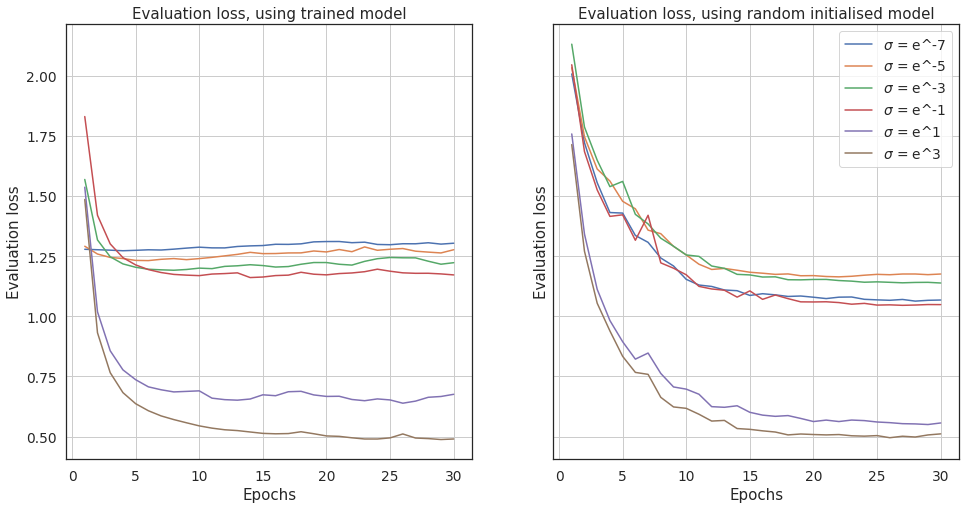

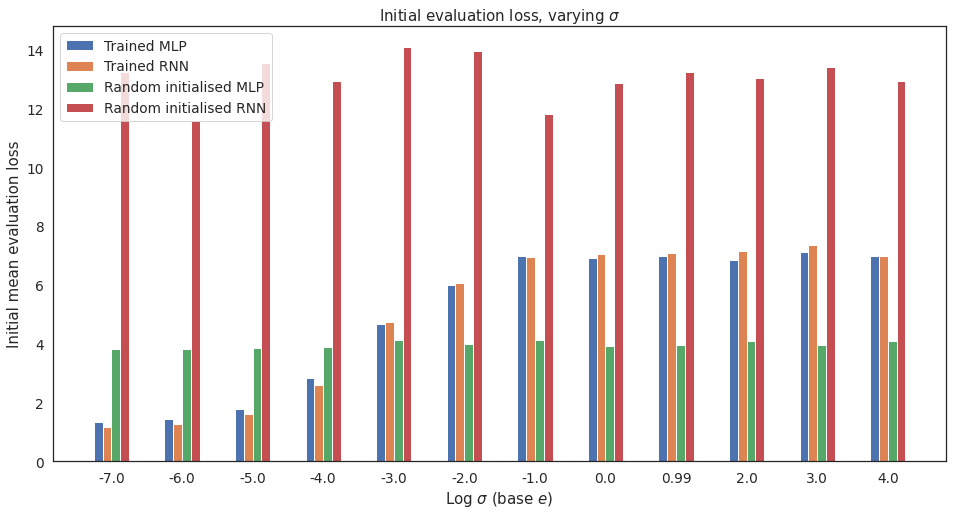

In [53]:
(mlp_mean_transfer, mlp_std_transfer) = torch.load( './temp/MLP_plasticity_transfer_n.pt')
(mlp_mean_retrain, mlp_std_retrain) = torch.load( './temp/MLP_plasticity_retrain_n.pt')
(rnn_mean_transfer, rnn_std_transfer) = torch.load( './temp/RNN_plasticity_transfer_n.pt')
(rnn_mean_retrain, rnn_std_retrain) = torch.load( './temp/RNN_plasticity_retrain_n.pt')

# normal scale loss
n_sigma = sigmas.shape[0]
num_epochs=30

f, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(16,8))
plt.subplot(121)
plt.title('Evaluation loss, using trained model')
n_sigmas = len(sigmas)
for i in range(0, n_sigma, 2): # for each sigma
    ax1.plot(np.arange(1, num_epochs+1),
             mlp_mean_transfer[1][i,:],
             # yerr=mlp_std_transfer[1][i,:],
             label=r'$\sigma$ = e^' + str(-7+i))
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Evaluation loss')

plt.subplot(122)
plt.title('Evaluation loss, using random initialised model')
for i in range(0, n_sigma, 2):
    ax2.plot(np.arange(1, num_epochs+1,),
                 mlp_mean_retrain[1][i,:],
                 # yerr=mlp_std_retrain[1][i,:],
                 label=r'$\sigma$ = e^' + str(-7+i))
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Evaluation loss')

plt.legend(bbox_to_anchor =(1, 1))

plt.savefig('./figures/plasticity_mlp.png',dpi=250, bbox_inches='tight')
plt.show()

width = 0.5
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(np.arange(mlp_mean_transfer[2].shape[0]) - width*3/8,
       mlp_mean_transfer[2], width/4, 
       # yerr = std_transfer[2], 
       label='Trained MLP')
ax.bar(np.arange(rnn_mean_transfer[2].shape[0]) - width*1/8,
       rnn_mean_transfer[2], width/4,
       # yerr = std_transfer[2],
       label='Trained RNN')

ax.bar(np.arange(mlp_mean_retrain[2].shape[0]) + width*1/8,
       mlp_mean_retrain[2], width/4, 
       # yerr=std_retrain[2],
       label='Random initialised MLP')
ax.bar(np.arange(rnn_mean_retrain[2].shape[0]) + width*3/8, 
       rnn_mean_retrain[2], 
       width/4, 
       # yerr=std_retrain[2], 
       label='Random initialised RNN')
plt.legend()
plt.xticks(np.arange(n_sigmas), [str(i.cpu().numpy())[:4] for i in torch.log(sigmas)])
plt.xlabel(r'Log $\sigma$ (base $e$)')
plt.ylabel('Initial mean evaluation loss')
plt.title(r'Initial evaluation loss, varying $\sigma$')
plt.savefig('./figures/plasticity_2.png',dpi=250, bbox_inches='tight')
plt.show()

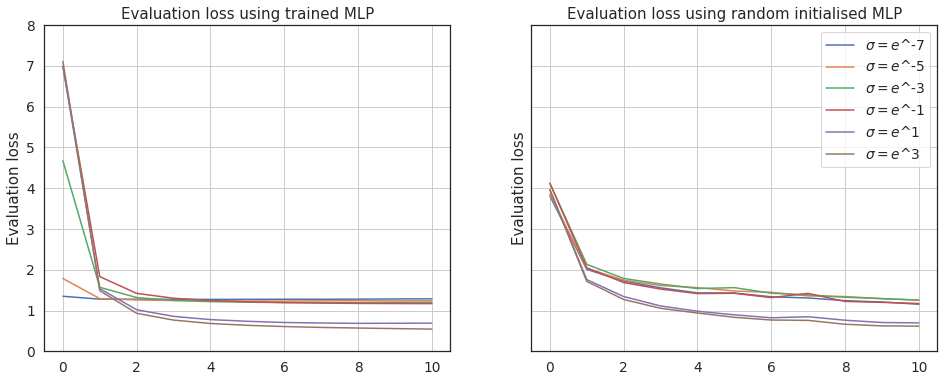

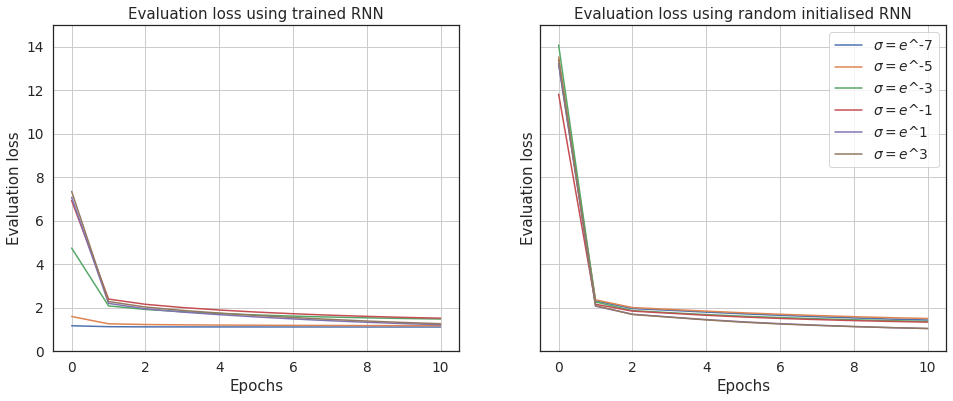

In [50]:
(mlp_mean_transfer, mlp_std_transfer) = torch.load( './temp/MLP_plasticity_transfer_n.pt')
(mlp_mean_retrain, mlp_std_retrain) = torch.load( './temp/MLP_plasticity_retrain_n.pt')
(rnn_mean_transfer, rnn_std_transfer) = torch.load( './temp/RNN_plasticity_transfer_n.pt')
(rnn_mean_retrain, rnn_std_retrain) = torch.load( './temp/RNN_plasticity_retrain_n.pt')


# stack initial loss
mlp_transfer_mean, mlp_transfer_std = torch.vstack((mlp_mean_transfer[2], mlp_mean_transfer[1].T)).T, torch.vstack((mlp_std_transfer[2], mlp_std_transfer[1].T)).T
mlp_retrain_mean, mlp_retrain_std = torch.vstack((mlp_mean_retrain[2], mlp_mean_retrain[1].T)).T, torch.vstack((mlp_std_retrain[2], mlp_std_retrain[1].T)).T

rnn_transfer_mean, rnn_transfer_std = torch.vstack((rnn_mean_transfer[2], rnn_mean_transfer[1].T)).T, torch.vstack((rnn_std_transfer[2], rnn_std_transfer[1].T)).T
rnn_retrain_mean, rnn_retrain_std = torch.vstack((rnn_mean_retrain[2], rnn_mean_retrain[1].T)).T, torch.vstack((rnn_std_retrain[2], rnn_std_retrain[1].T)).T



n_sigmas = len(sigmas)
num_epochs=10

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16,6))
plt.subplot(121)
plt.title('Evaluation loss using trained MLP')

for i in range(0, n_sigma, 2): # for each sigma
    ax1.errorbar(np.arange(0, num_epochs+1), mlp_transfer_mean[i,:num_epochs+1], label=r'$\sigma = e$^' + str(-7 + i))
plt.grid()
plt.ylabel('Evaluation loss')


plt.subplot(122)
plt.title('Evaluation loss using random initialised MLP')
for i in range(0, n_sigma, 2):
    ax2.errorbar(np.arange(0, num_epochs+1), mlp_retrain_mean[i,:num_epochs+1], label=r'$\sigma = e$^' + str(-7 + i))
plt.grid()
plt.ylabel('Evaluation loss')

plt.ylim([0,8])
plt.legend(bbox_to_anchor =(1, 1))
plt.savefig('retrain_generalisation_mlp', dpi=250, bbox_inches='tight')

plt.show()



f, (ax3, ax4) = plt.subplots(1, 2, sharey=True, figsize=(16,6))

plt.subplot(121)
plt.title('Evaluation loss using trained RNN')

for i in range(0, n_sigma, 2): # for each sigma
    ax3.errorbar(np.arange(0, num_epochs+1), rnn_transfer_mean[i,:num_epochs+1], label=r'$\sigma = e$^' + str(-7 + i))
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Evaluation loss')


plt.subplot(122)
plt.title('Evaluation loss using random initialised RNN')
for i in range(0, n_sigma, 2):
    ax4.errorbar(np.arange(0, num_epochs+1), rnn_retrain_mean[i,:num_epochs+1], label=r'$\sigma = e$^' + str(-7 + i))
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Evaluation loss')
plt.ylim([0,15])
plt.legend(bbox_to_anchor =(1, 1))
plt.savefig('retrain_generalisation_rnn', dpi=250, bbox_inches='tight')
plt.show()

###### 